In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.preprocessing import StandardScaler
from itertools import combinations


from statsmodels.formula.api import logit
import numpy as np
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler


#Tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

#Ensemble
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import AdaBoostClassifier

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import LabelBinarizer

from scipy.spatial import distance


In [2]:
pd.options.display.max_rows = 500
pd.options.display.max_columns = 1000

## Questionnaire and Summary

__Note: More explanation is offered as we go along the notebook__

1. Which Machine Learning model have you picked and why? Feel free to experiment
   with 1-3 model types and pick the best one.
   
- The clusters between different categories are not linearly separable.
- The correlation between different classes and features is very weak 
- For prediction,parametric models might not give the best results especially for predictions.
- For analysis , I have parametric model output to analyze the significance of each feature for the coaches
- I have tried statsmodels MNLogit, LogisticRegression , Ensemble - RandomForestClassifier models. 
- Logistic Regression has shown improvement when interactive features were created. More below
- Ensemble models like the RFClassifier showed improvement in results when tuned 

- Hence my choice was RandomForestClassifier. Please refer Miscallaenous for discussion on other models
  
2. How are you evaluating the results of your model? (e.g. What metrics and
    visualisations are most useful)
   
  __Probabilistic metrics__ were chosen
  - Brier score, Brier Skill Score
  - Ignorance score 
  - Jensen-Shannon divergence
  - More information in the notebook below
  
  - Brier score is more suitable for __imbalanced__ dataset

- Brier score is the difference between probabilties of each category squared and averaged over all rows
- Brier score can be mathematically decomposed into Reliability - Resolution + Uncertainty.
- The uncertainty cancels out when using Brier skill score
- __Brier Skill Score__ is the relative improvement our model offers over a baseline model(or a No Skill model). Here since the number of runs , wickets are heavily imbalanced classes, BSS against a baseline model would give an good indicator of the performance

- __Ignorance score__ is also a proper scoring rule and useful for measuring proabilistic forecasts.It is equal to the sum of logs of individual proabilities of each class

- It is like entropy. The lower the better

- KL divergence compares the divergence of one distribution over the other by calculating relative entropy. However the upper bound is not bounded.
- KL divergence is not symmetrical
- JS divergence compares the divergence of two distributions  from one the other and vice versa
- JS divergence is symmetrical
- Most importantly JS Divergence is bounded value between 0 and 1 (base2)   or btw 0 and 0.69(base e)
- The lower JS Divergence the better
- Below result indicates that the two distributions diverge by 0.74 which indicates not the best possible result. It can be b
- Particularly since 3's , 5's and wickets are rare, the distributions can be __calibrated__ 

  
 __Label based metrics were not chosen__
  - Since the dataset is imbalanced and an inherent problem in the domain of cricket & other features such batsmen skills,pitch conditions, context of the game are not included, it becomes hard to predict the various classes (boundaries,sixes,wickets) etc. Hence label based metrics such as accuracy score,F1 score, weighted accuracy are not considered.

3. Does the variance of your model's output distribution match the variance of the target
    distribution (runs)?
- It does not match
- Since I have chosen classification models, I have used entropy as an equivalent for measuring the variance 
- Since the dataset is heavily imbalanced and there are no strong discriminating features (weak correlation and see feature importance of RF), the predicted distribution is skewed towards the majority class 
- Higher dimensions or interaction features could help in further modelling

4. Let’s say you’re working alongside some cricket coaches in the IPL. How would you
    explain the learnings of your model to a coach, about the best areas to target as a
    bowler?
    
    __From Visalizations:__
    
- release speed and swing angle have similar distribution for wickets vs 4s , even for outliers as well
- Indicates that __wicket taking deliveries__ have __risk of being hit for 4s and 6s as well__

- __Higher chance of taking a wicket__ when swing angle is just about right with in the limits of __-10,10__
- __Swing Angle__ has a clear indication that if the swingle angle is just right , then the chances of getting wickets is higher
- The __bounce_velocity_ratio_z__  the lower much better. If the ball slows off the pitch or the bowler is bowling slower balls is much more effective controlling score rate (runs =0, runs=1)
- Slower balls might not be __wicket taking__ deliveries but effective in __controlling run flow__
- __bounce_position_x__
    - __Good length/fulltosss__ is much better than short pitch deliveries

- Other patterns from x,y,z,release angle,bounce angle, drop angle can be inferred from the below visualizations

    __From StatsModel:__
    Please refer MNLogit.summary() / Summary2() in Modeling Section
    
    For each category like wickets, boundaries advise on contribution of different features are significant (p-value) as shown in the statsmodels Summary based such as 
    
    release_speed_kph,
    release_position_z
    bounce_position_x
    crease_position_z
    stumps_position_z
    release_angle
    bounce_angle
    batting_hand_right
    bowling_hand_right
    bowling_type_spin
    
    __From Ensemble models:__
    
    Please refer feature importance from RF model. 
- bounce_position_x( Length of the delivery)  has the highest importance. It implies that ball length(good,short,full toss) play a critical role splitting the nodes of the Decision tree.
- Similar z and y coordinates of crease,stump (ball is close to stumps or far and the height of the ball) play a role
- swing_angle and deviation play a role, although this classification model is meant for all categories (runs=0,1,2,3,4,5,6,wicket)

5. What future steps might you want to explore if you had another week of coding for
    this model?

    
- Discretized bins - I have attempted to discretize the features into bins classifying speed of a ball as slow,medium,fast, express or lenght of the ball as good,short,full etc
    
- Imputation - fill na instead of drop na , replace with mean/distribution based etc

- Interaction - As there is no strong correlation, I constructed interactive variables ex: swing_angle * deviation which might help in more predictive power shich showed promising results
    
- Calibrating probabilities for rare events 0 wickets/3's/5's 
    
- Trying XGB, Gradient Boosting Classifiers 
    
- SVM since clusters are embedded and not linearly separable


In [3]:
cric_df = pd.read_csv('data.csv (2)/data.csv')

### EDA

In [4]:
# cric_df[cric_df.duplicated()]

In [5]:
# cric_df.query('release_speed_kph == 126.42')

In [6]:
## Drop duplicates
df = cric_df.drop_duplicates()
df.shape

(200501, 20)

In [7]:
df.describe()

,release_speed_kph,swing_angle,deviation,release_position_y,release_position_z,bounce_position_y,bounce_position_x,crease_position_y,crease_position_z,stumps_position_y,stumps_position_z,bounce_velocity_ratio_z,release_angle,drop_angle,bounce_angle,runs,wicket
count,200222.000000,200422.000000,194881.000000,200415.000000,200291.000000,200354.000000,200408.000000,200424.000000,200394.000000,200412.000000,200394.000000,200385.000000,200421.000000,200399.000000,200397.000000,200501.000000,200501.000000
mean,113.314446,0.181158,-0.205384,-0.323683,2.003816,-0.141875,6.141215,-0.076186,0.668253,-0.059798,0.744045,-0.607780,-5.508647,-13.918803,9.529592,1.291181,0.049965
std,21.575801,1.224183,1.884730,0.636288,0.131183,0.336757,2.844749,0.341459,0.318018,0.366906,0.320677,0.077296,4.183112,2.615858,2.290576,1.626928,0.217873
min,40.200000,-24.500000,-24.080000,-3.000000,1.020000,-1.300000,-8.930000,-1.540000,0.000000,-1.800000,0.000000,-2.880000,-43.760000,-44.210000,0.020000,0.000000,0.000000
25%,90.800000,-0.480000,-0.860000,-0.750000,1.930000,-0.380000,4.470000,-0.290000,0.480000,-0.290000,0.560000,-0.650000,-8.340000,-15.790000,7.870000,0.000000,0.000000
50%,119.260000,0.190000,-0.040000,-0.570000,1.990000,-0.170000,6.120000,-0.080000,0.640000,-0.060000,0.720000,-0.610000,-5.270000,-13.950000,9.280000,1.000000,0.000000
75%,132.840000,0.880000,0.620000,0.160000,2.080000,0.080000,7.980000,0.140000,0.820000,0.170000,0.890000,-0.560000,-2.400000,-11.980000,10.970000,1.000000,0.000000
max,168.670000,24.360000,24.290000,2.980000,6.710000,1.300000,18.730000,1.900000,3.380000,1.950000,3.360000,0.000000,43.550000,-0.360000,44.220000,6.000000,1.000000


#### Imbalanced data set with more 1s and 2s than wickets and 3s and 5s. It is the nature of the game

In [8]:

# Check output cols
df.runs.value_counts(dropna=False,normalize=False),\
df.wicket.value_counts(dropna=False,normalize=False)


(runs
 1    78975
 0    74711
 4    22261
 2    13521
 6    10217
 3      780
 5       36
 Name: count, dtype: int64,
 wicket
 0    190483
 1     10018
 Name: count, dtype: int64)

In [9]:
target_cols = ['runs','wicket']

In [10]:
## No runouts , 
#df.query('runs == 0 and wicket > 0').crease_position_y.describe()
# .bowling_hand.value_counts()
# .bowling_type.value_counts()

#### Combine Wicket and runs 
#### Replace -1 for wicket

In [11]:
# Combine Wicket and runs 
## Give -1 for wicket
df.loc[:,'wicket']= df.wicket.replace(1,-1)
df.loc[:,'runs'] = df.runs + df.wicket

df =  df.drop('wicket',axis=1)

target_cols = ['runs']

In [12]:
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols

Index(['batting_hand', 'bowling_hand', 'bowling_type'], dtype='object')

In [13]:
df.bowling_type.value_counts()

bowling_type
pace    125883
spin     74245
Name: count, dtype: int64

In [14]:
df = pd.get_dummies(df,columns=cat_cols,drop_first=True)

In [15]:
feature_cols = df.columns[~df.columns.isin(target_cols)].tolist()

In [16]:
# df.runs.value_counts(normalize=True)

#### Visualize if wickets balls cluster is separable from the rest of the balls for a couple of dimensions..
- The cluster is not __linearly separable__

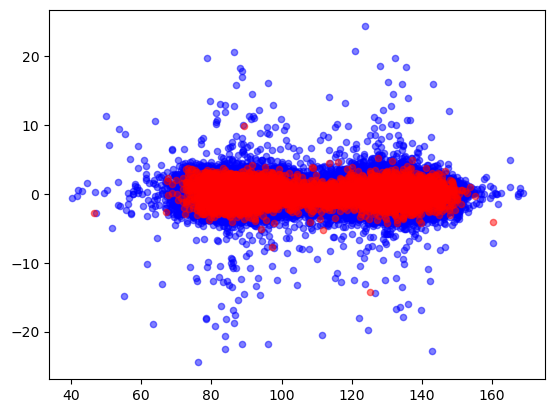

In [17]:
wicket_df= df.query('runs == -1')
nowicket_df = df.query('runs != -1')
cols = [ 'release_speed_kph' , 'swing_angle']
plt.scatter(nowicket_df[cols[0]],nowicket_df[cols[1]],color = 'blue',alpha =0.5,s= 20)
plt.scatter(wicket_df[cols[0]],wicket_df[cols[1]],color = 'red',alpha=0.5,s=20)

#### release speed and swing angle have similar distribution for wickets vs 4s , even for outliers as well
- Indicates that __wicket taking deliveries__ have __risk of being hit for 4s and 6s as well__


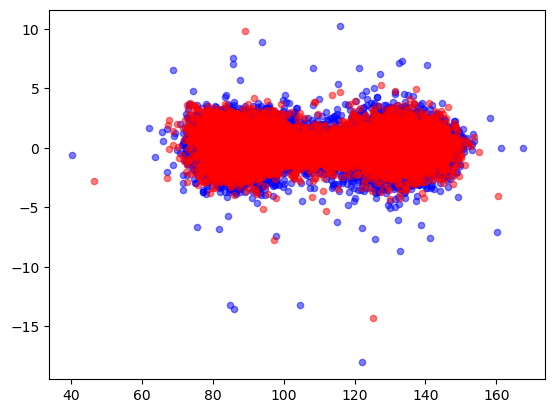

In [18]:
wicket_df= df.query('runs == -1')
nowicket_df = df.query('runs == 4')
cols = [ 'release_speed_kph' , 'swing_angle']
plt.scatter(nowicket_df[cols[0]],nowicket_df[cols[1]],color = 'blue',alpha =0.5,s= 20)
plt.scatter(wicket_df[cols[0]],wicket_df[cols[1]],color = 'red',alpha=0.5,s=20)

#### Visualize if wickets balls cluster is separable from the runs=0 , runs =1 ,runs=2..... to identify any patterns

#### Content for coach 
- __Higher chance of taking a wicket__ when swing angle is just about right with in the limits of __-10,10__
- __Swing Angle__ has a clear indication that if the swingle angle is just right , then the chances of getting wickets is higher
- The __bounce_velocity_ratio_z__  the lower much better. If the ball slows off the pitch or the bowler is bowling slower balls is much more effective controlling score rate (runs =0, runs=1)
- Slower balls might not be __wicket taking__ deliveries but effective in __controlling run flow__
- __bounce_position_x__
    - __Good length/fulltosss__ is much better than short pitch deliveries

- Other patterns from x,y,z,release angle,bounce angle, drop angle can be inferred from the below visualizations

swing_angle


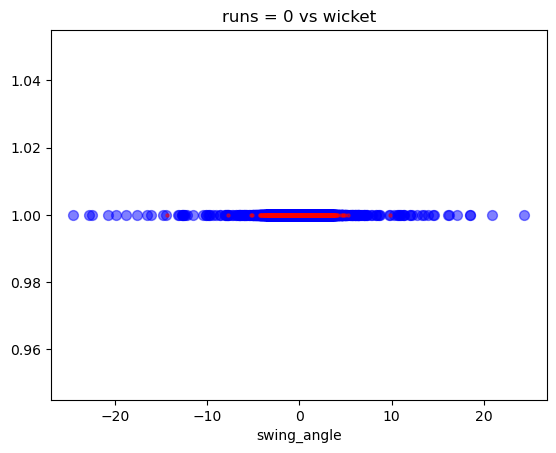

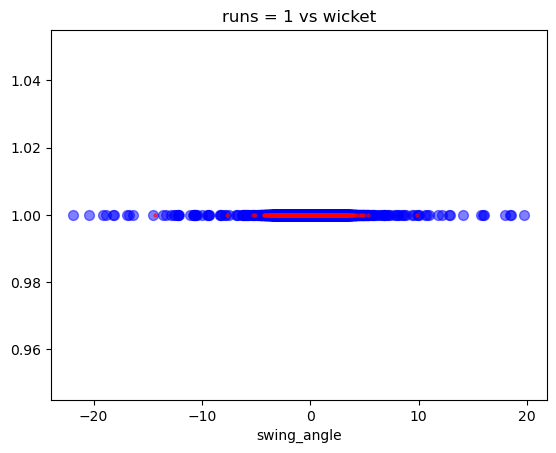

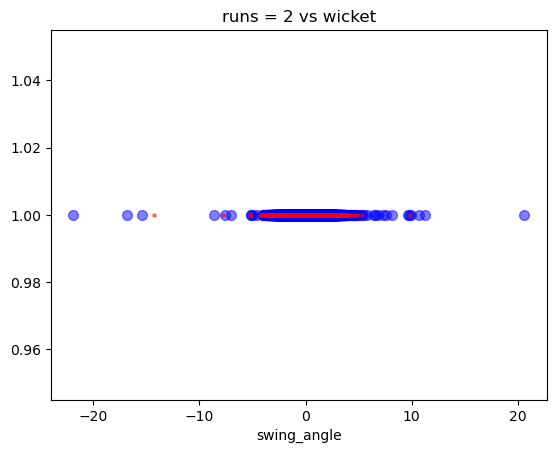

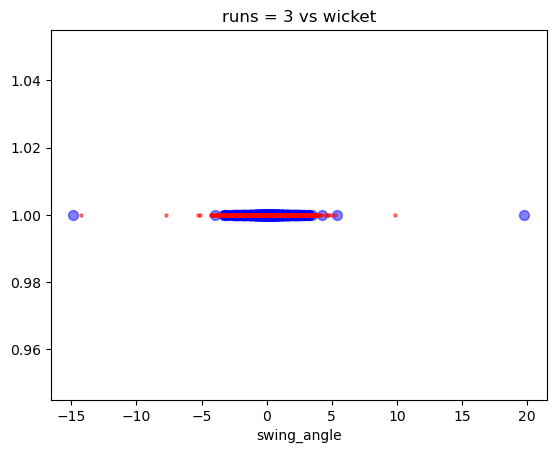

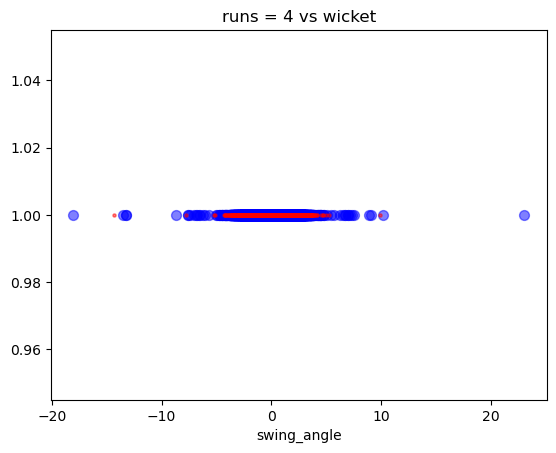

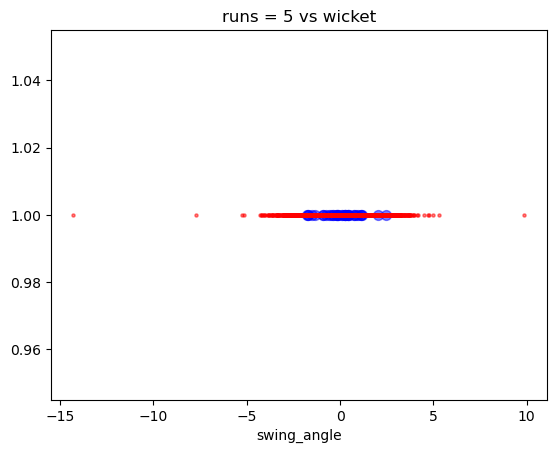

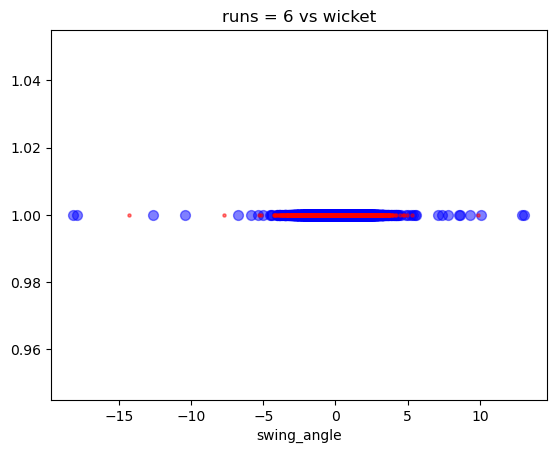

---------------------------------------------------------
deviation


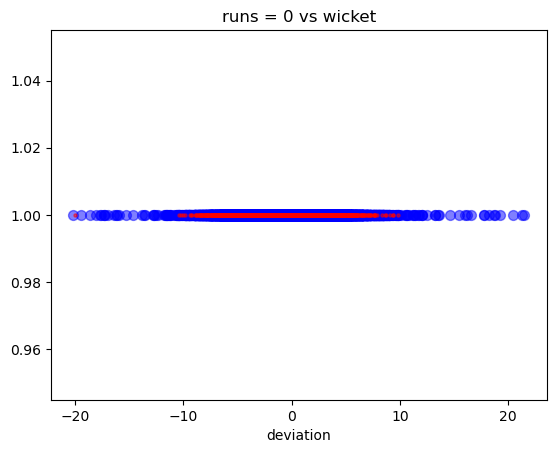

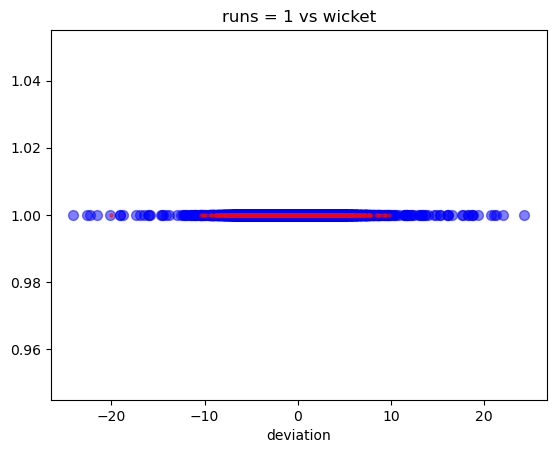

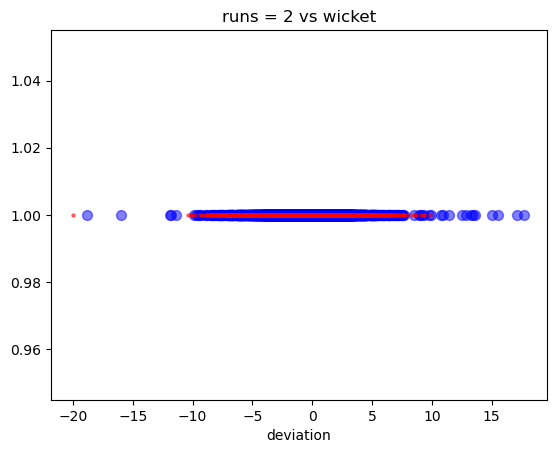

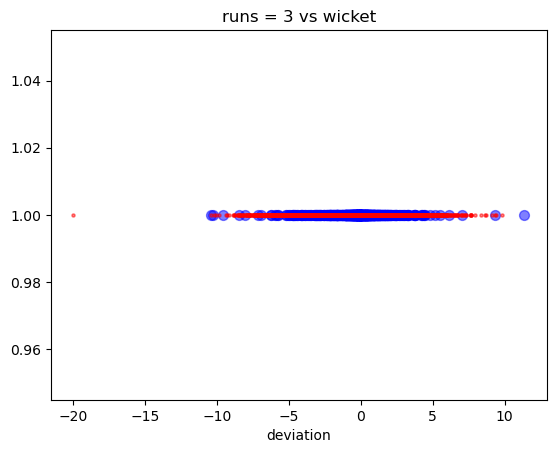

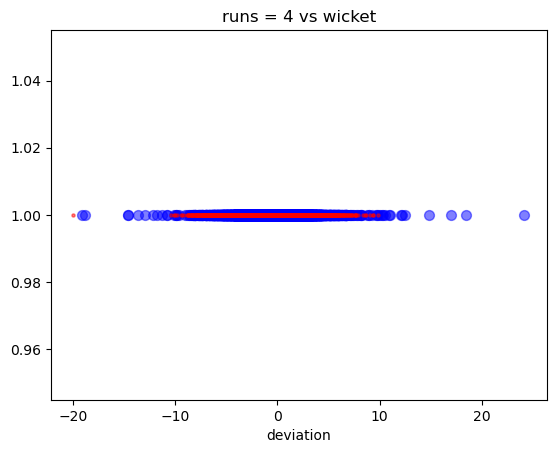

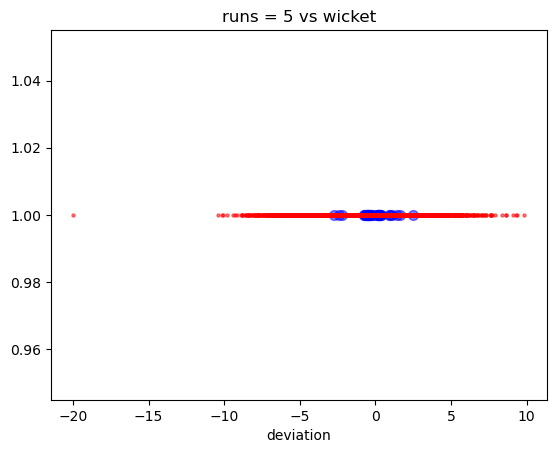

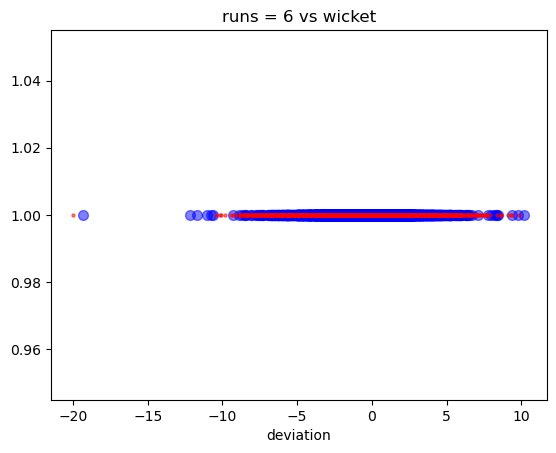

---------------------------------------------------------
bounce_velocity_ratio_z


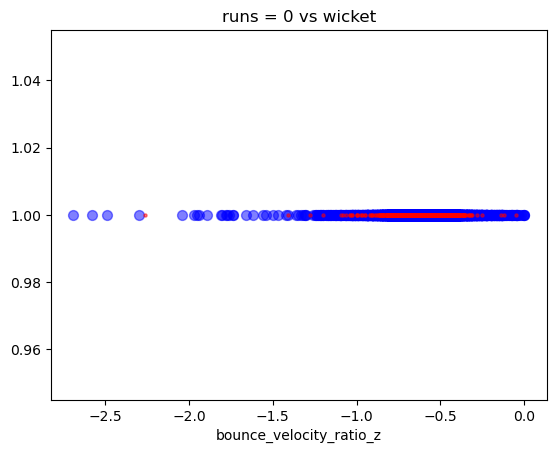

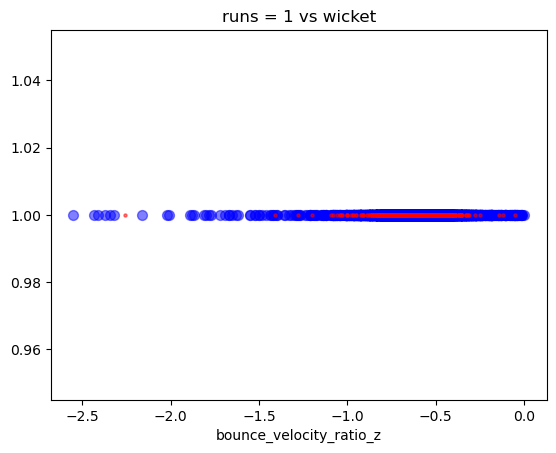

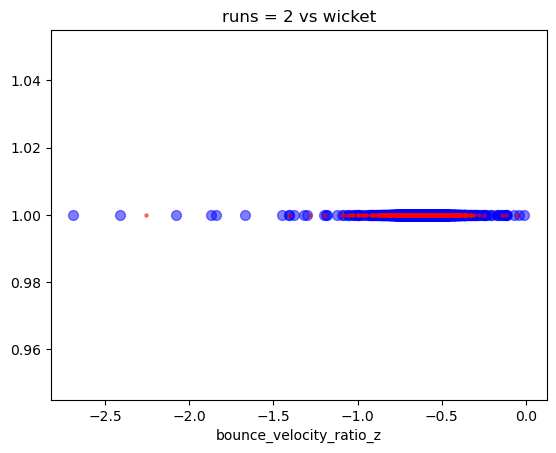

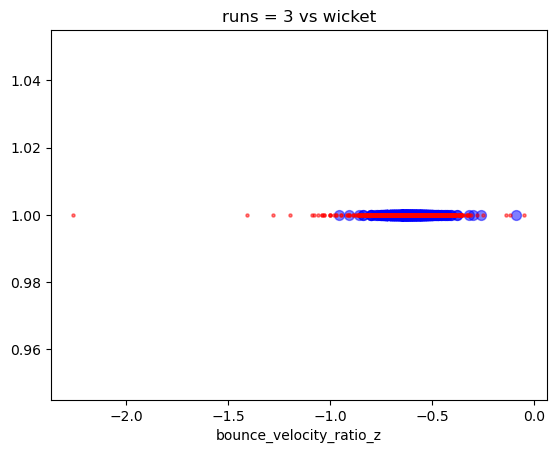

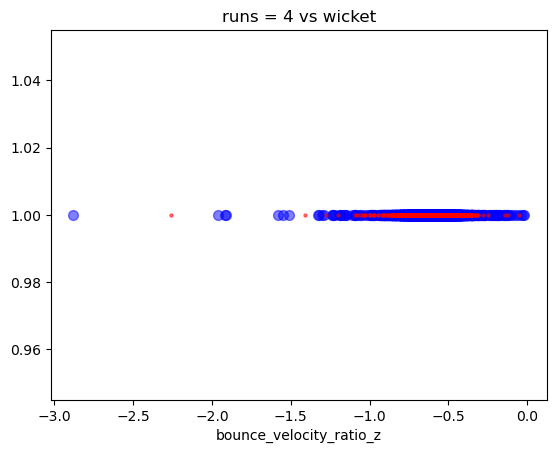

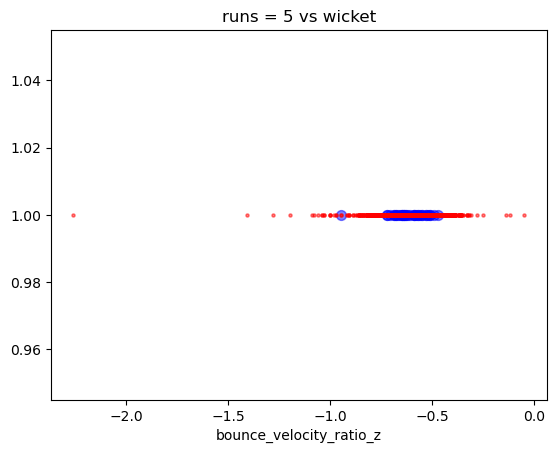

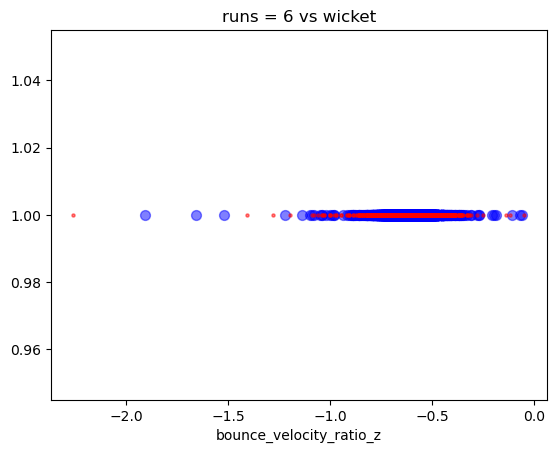

---------------------------------------------------------
bounce_position_x


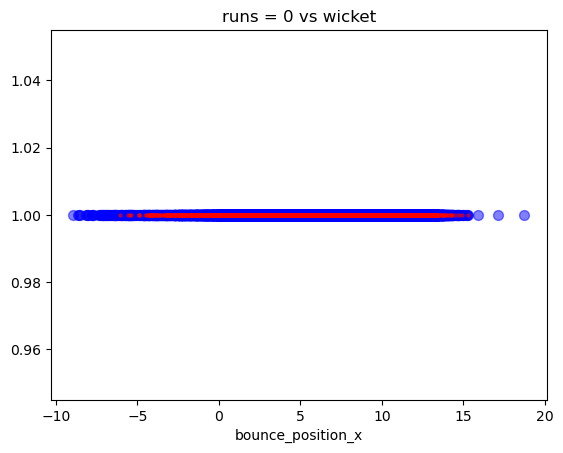

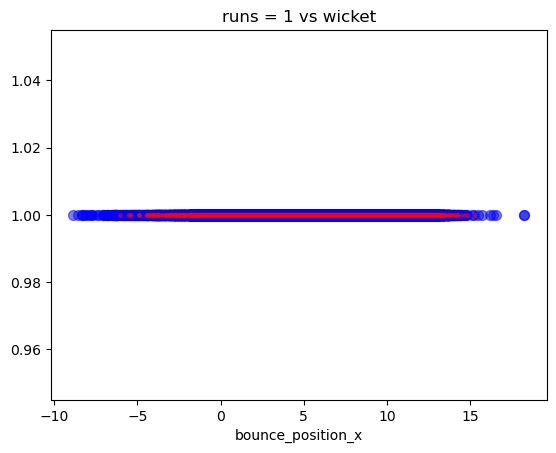

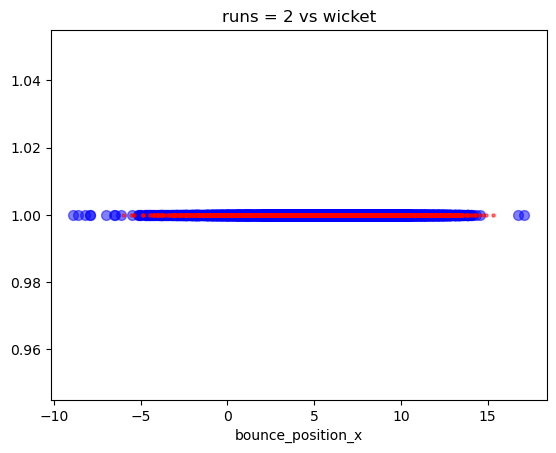

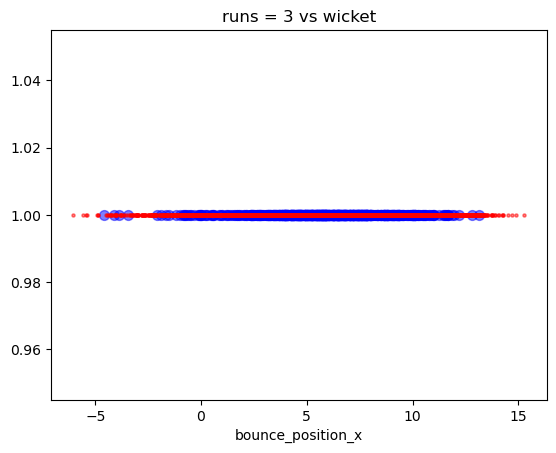

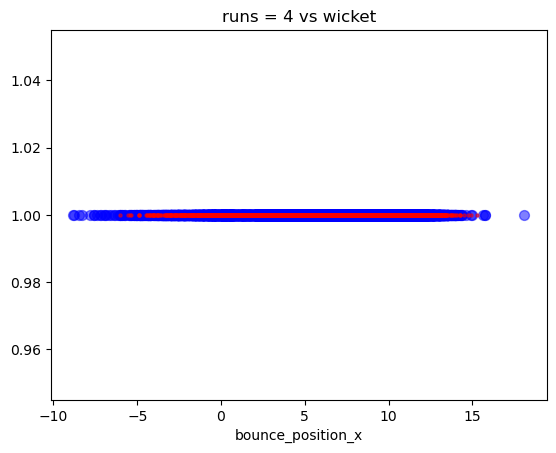

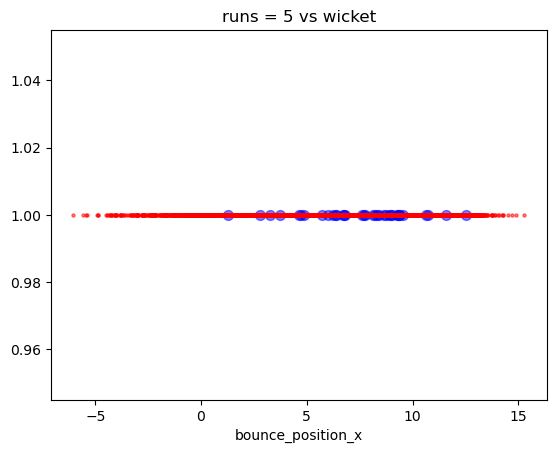

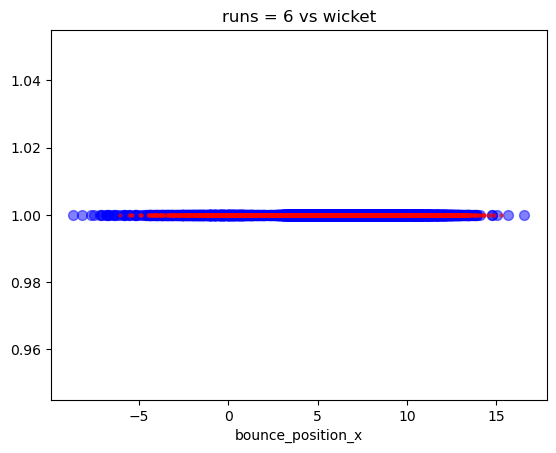

---------------------------------------------------------
stumps_position_z


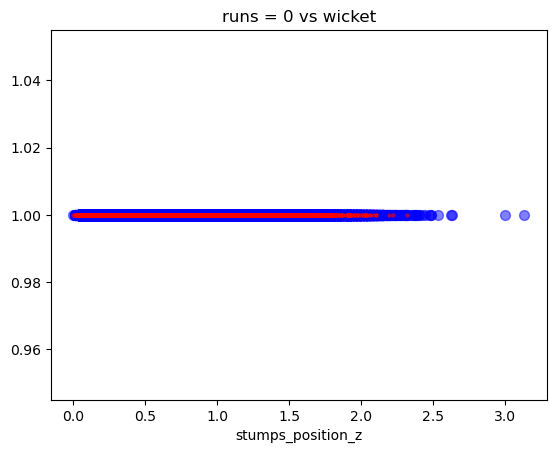

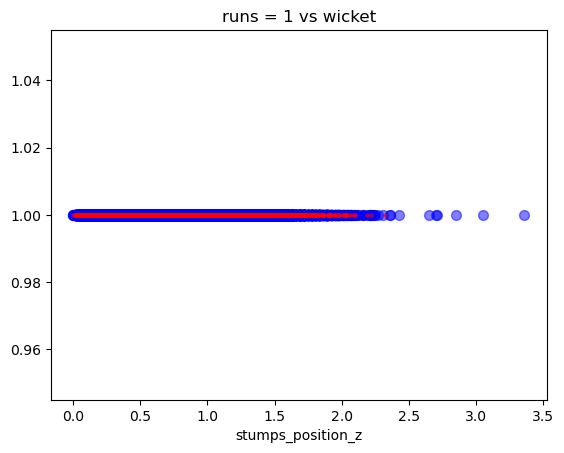

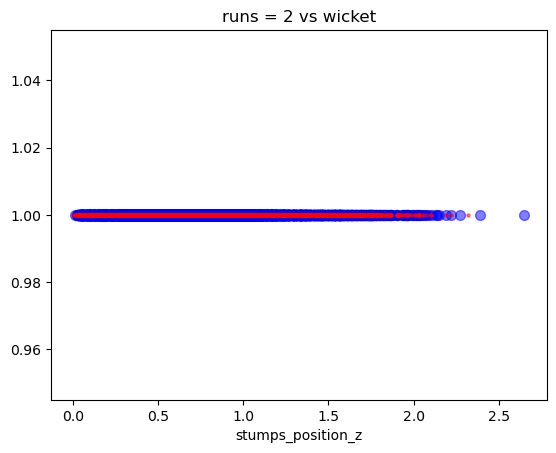

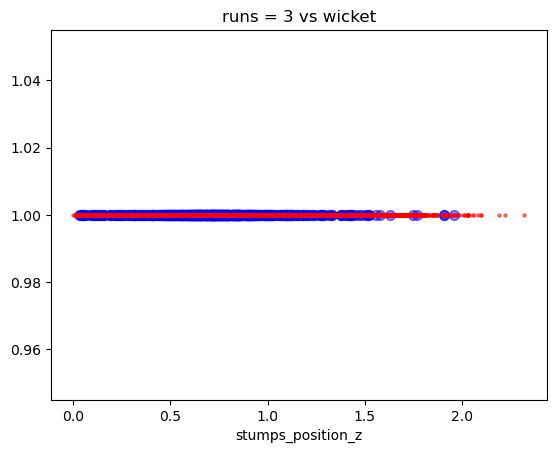

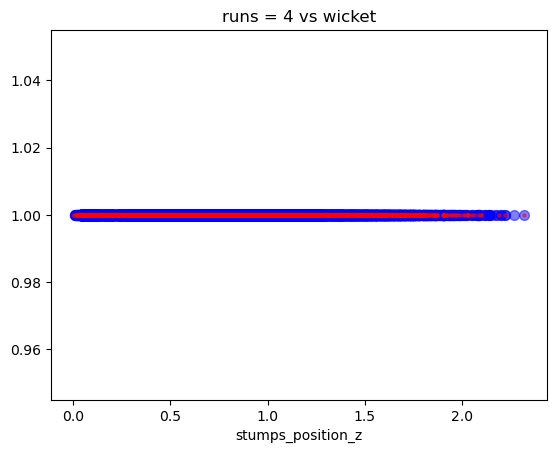

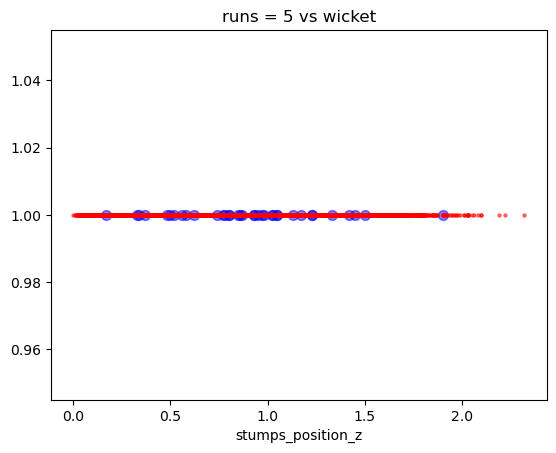

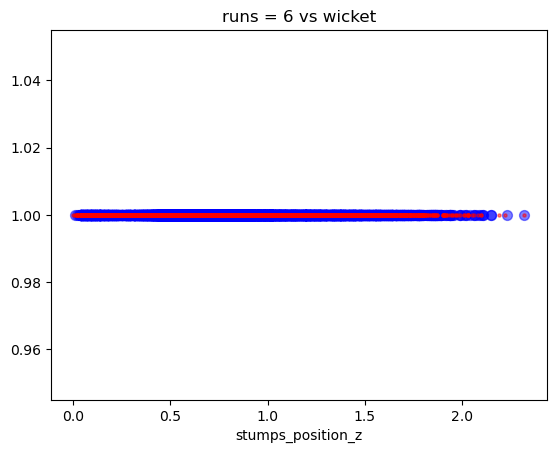

---------------------------------------------------------
stumps_position_y


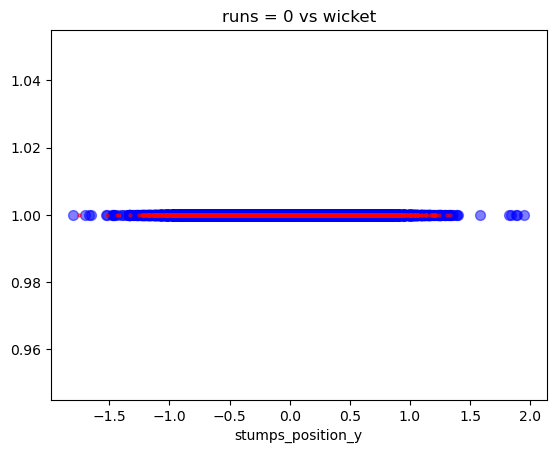

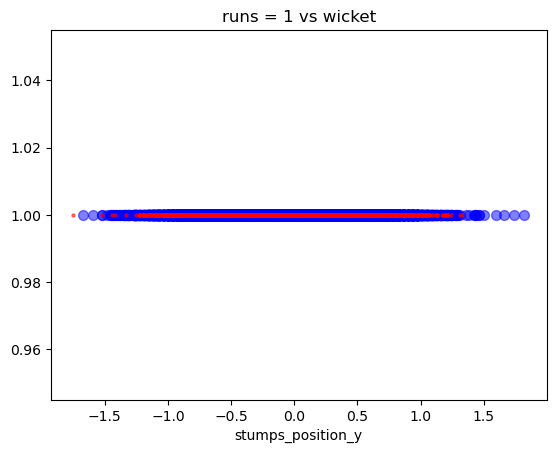

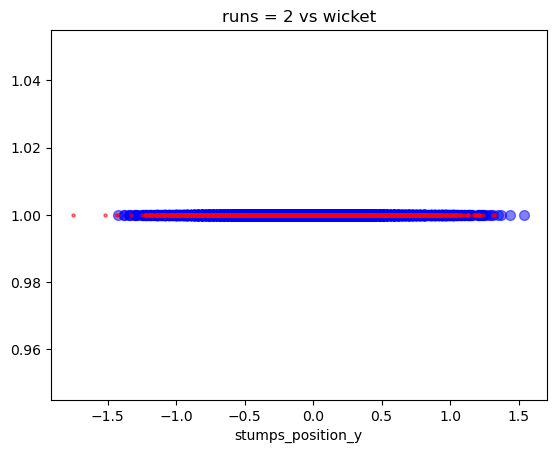

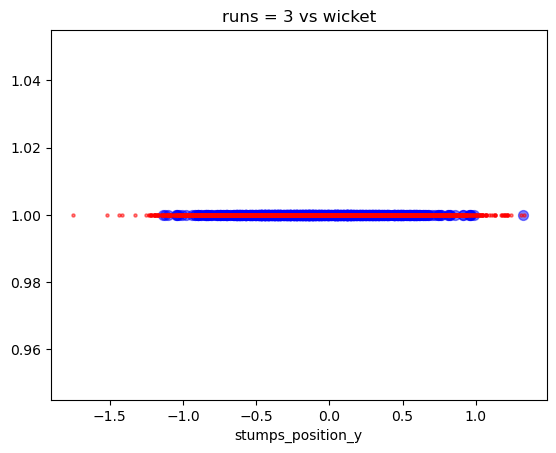

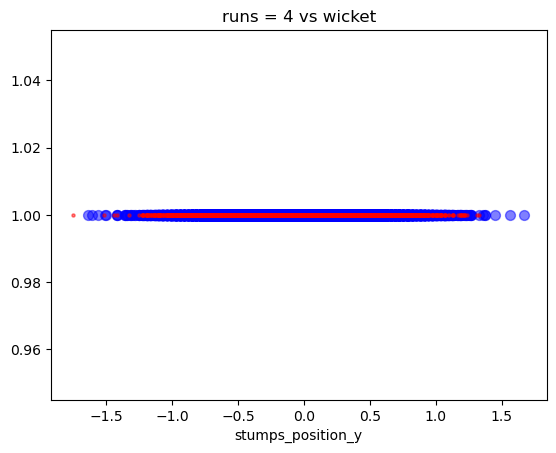

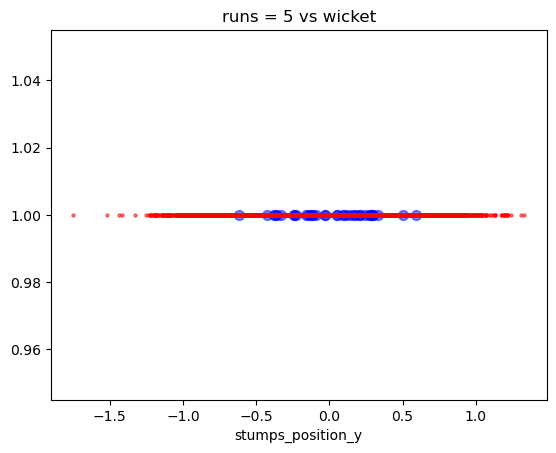

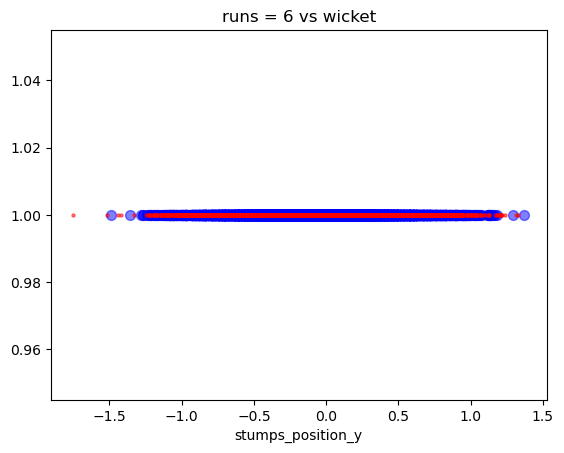

---------------------------------------------------------
bounce_position_y


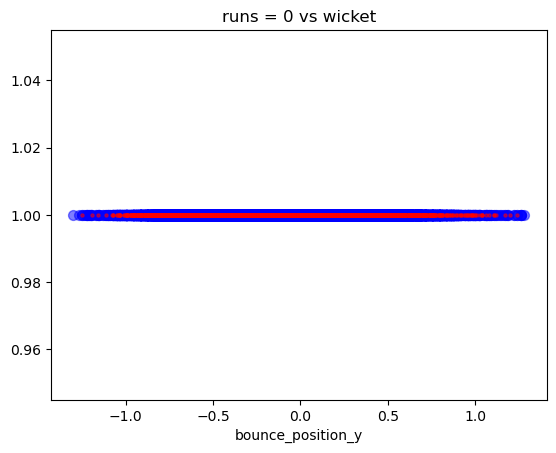

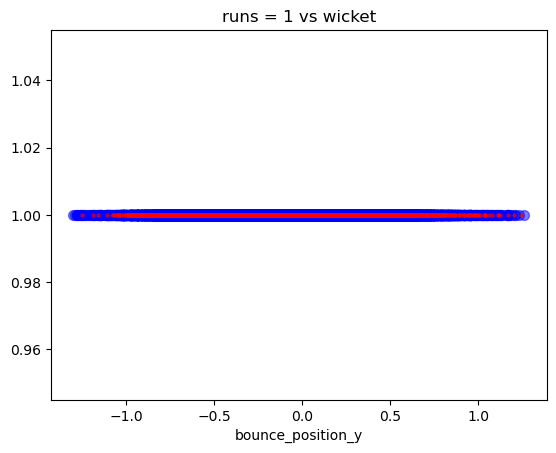

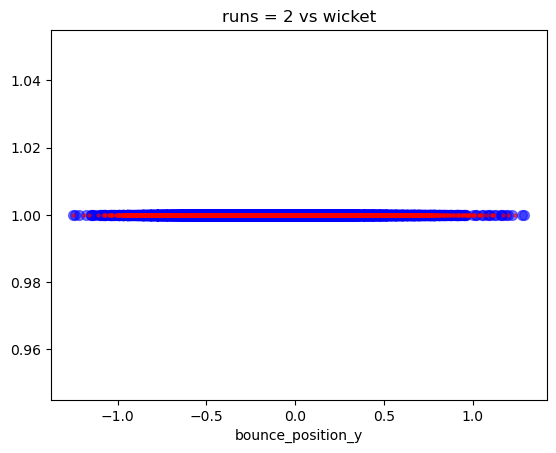

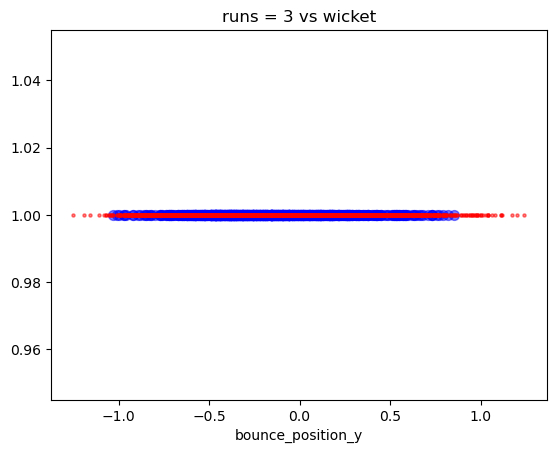

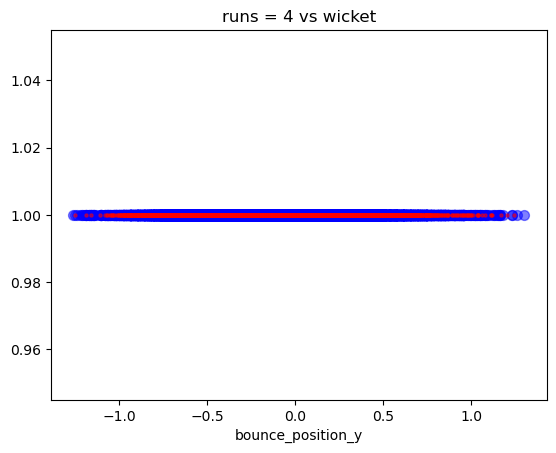

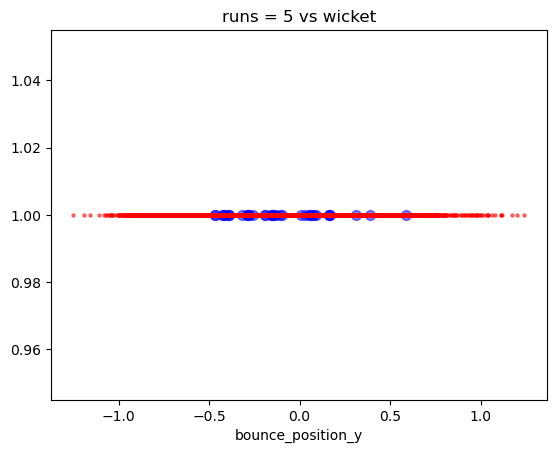

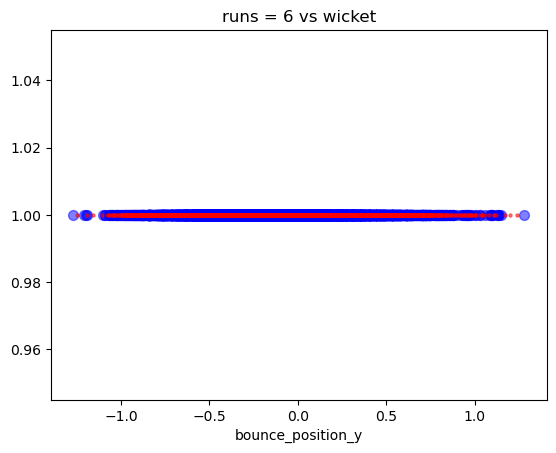

---------------------------------------------------------
release_speed_kph


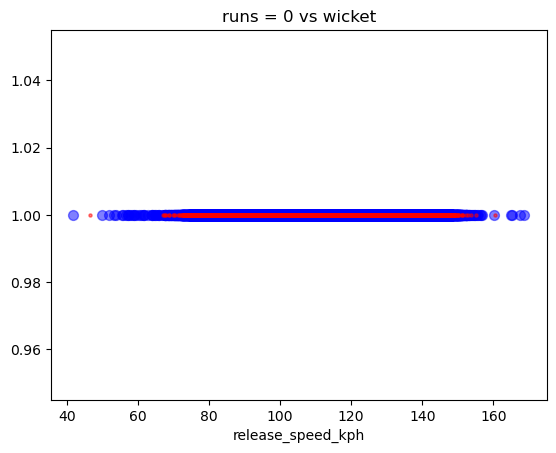

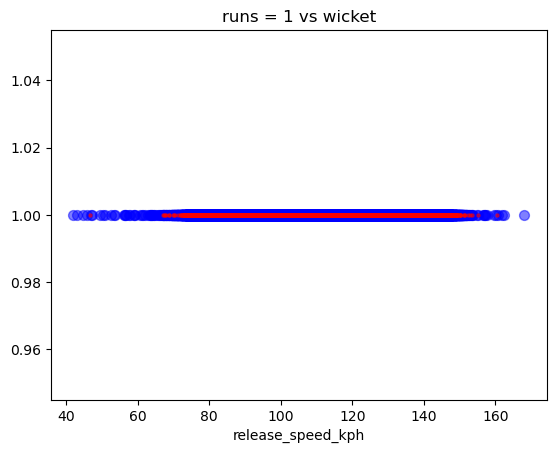

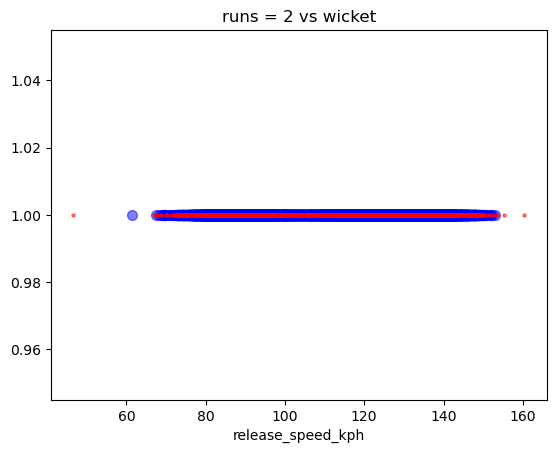

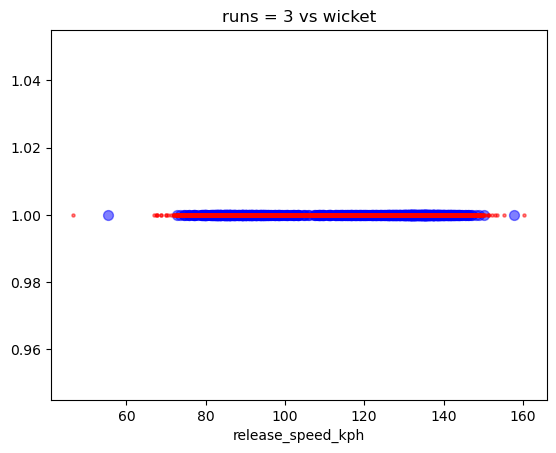

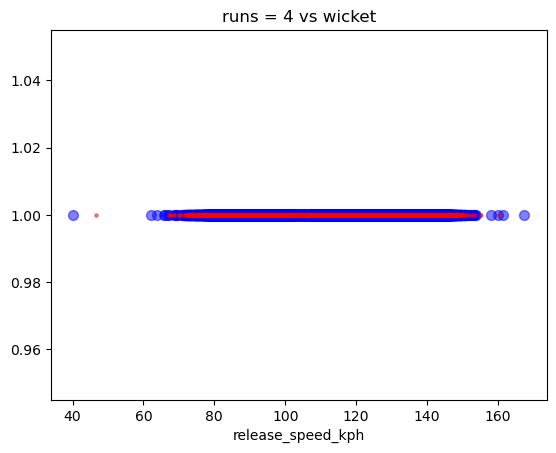

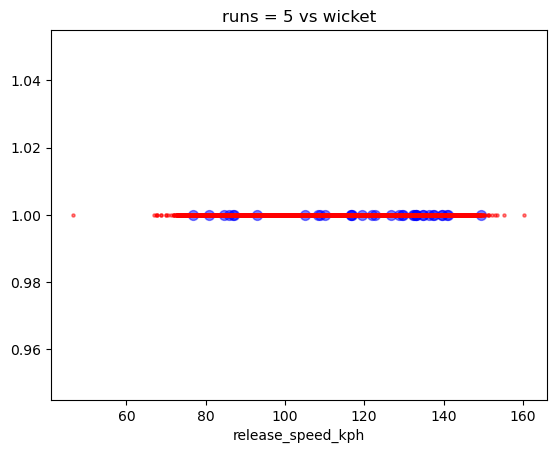

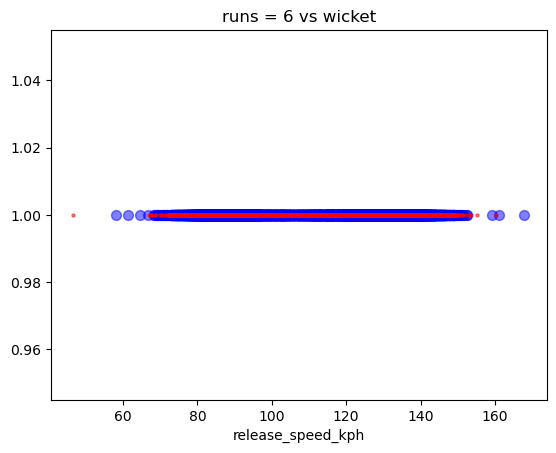

---------------------------------------------------------
release_position_z


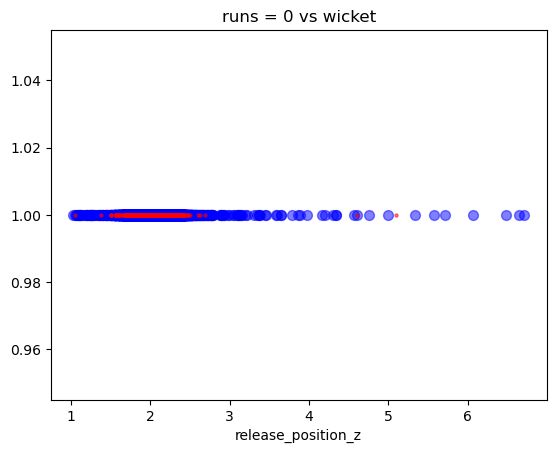

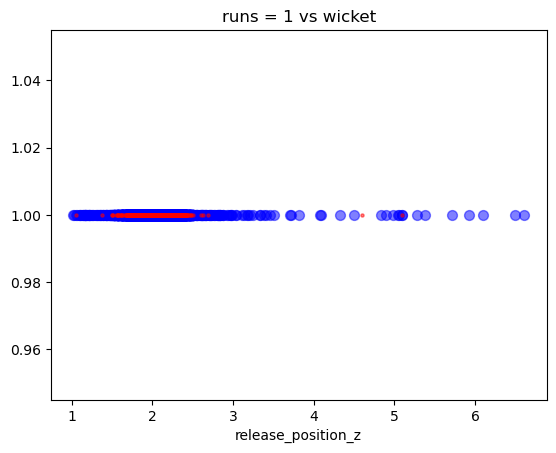

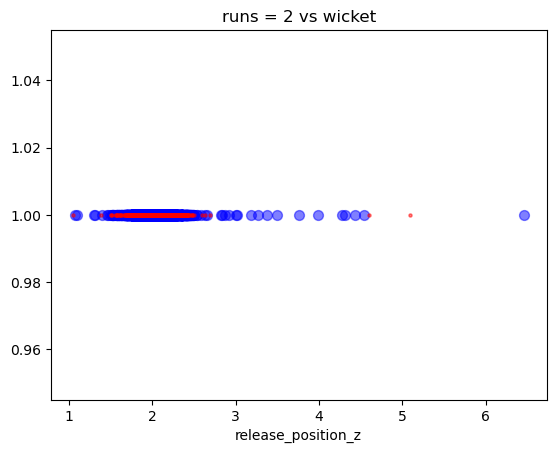

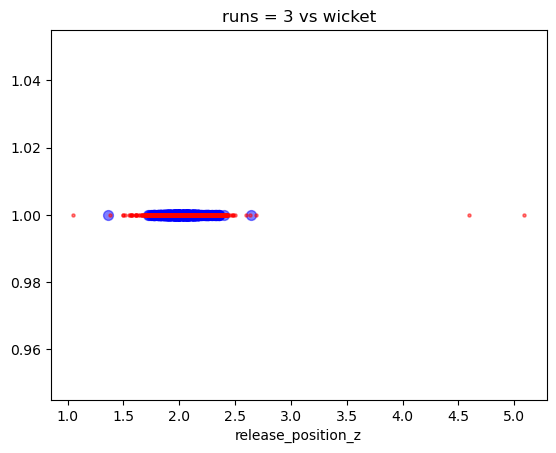

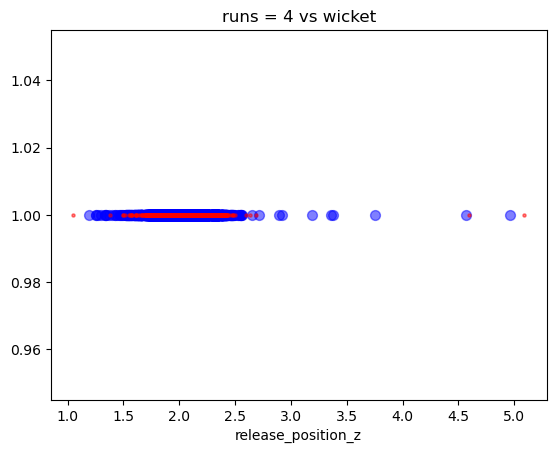

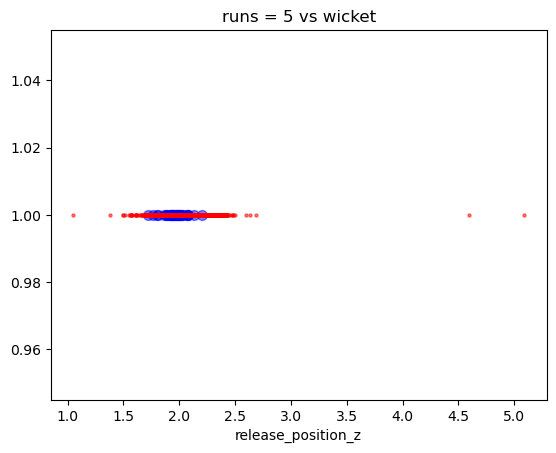

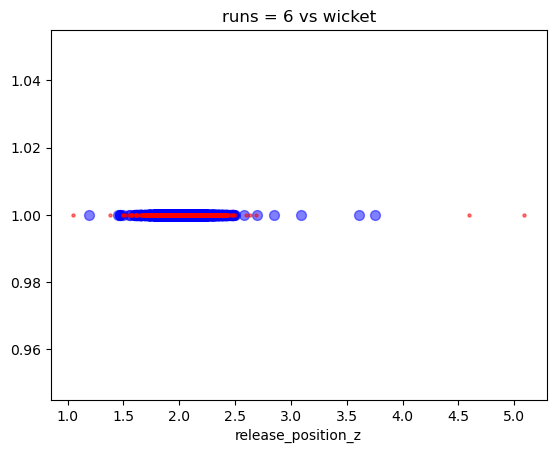

---------------------------------------------------------
release_position_y


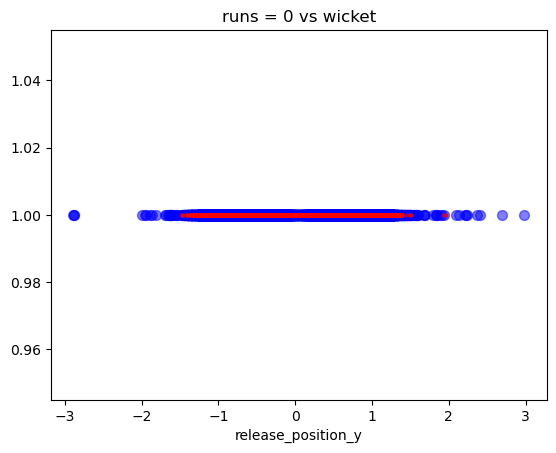

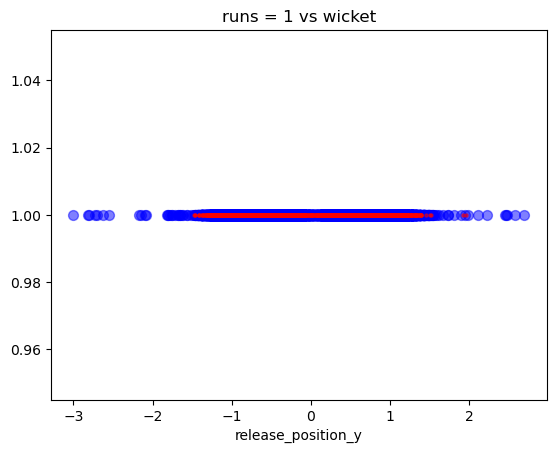

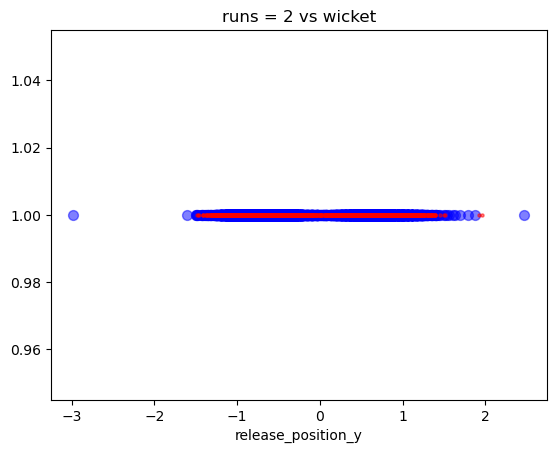

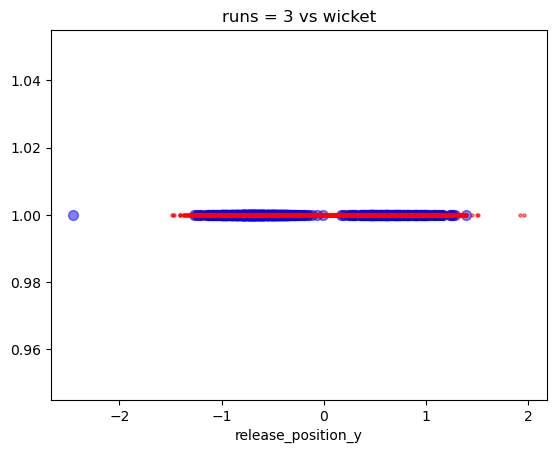

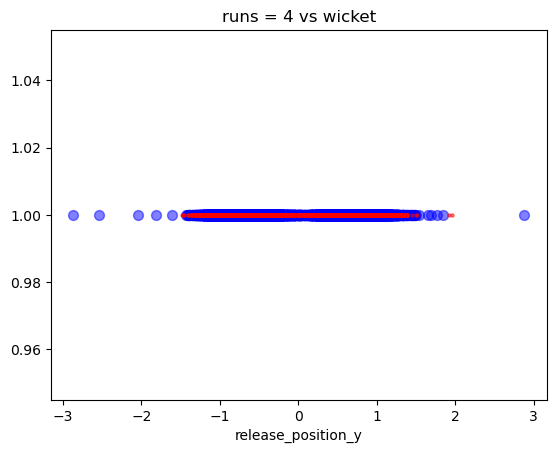

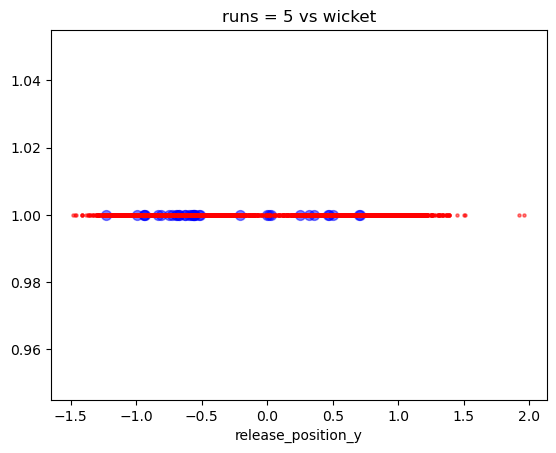

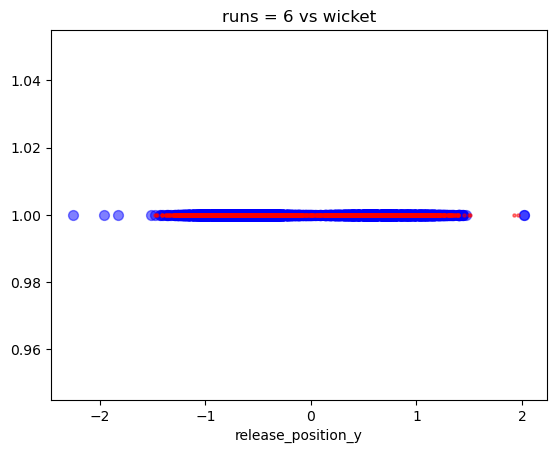

---------------------------------------------------------
release_angle


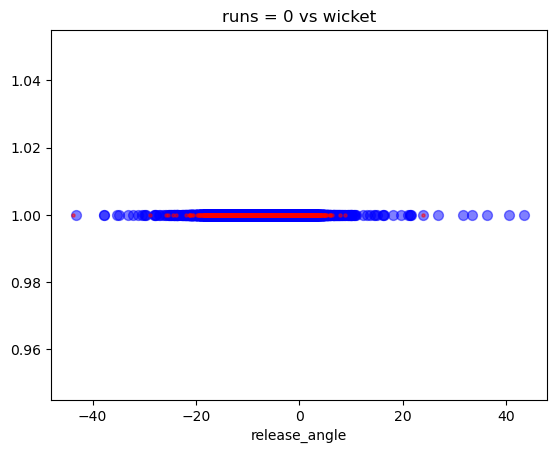

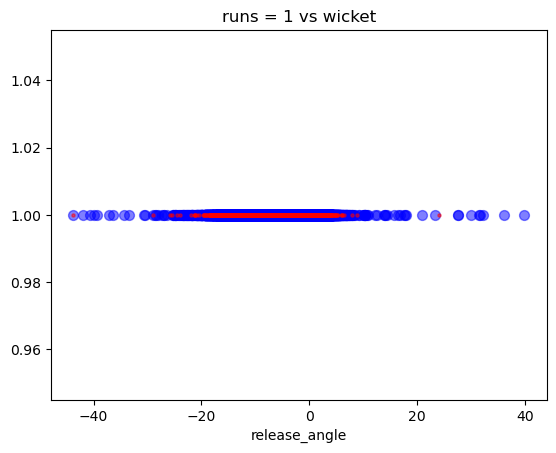

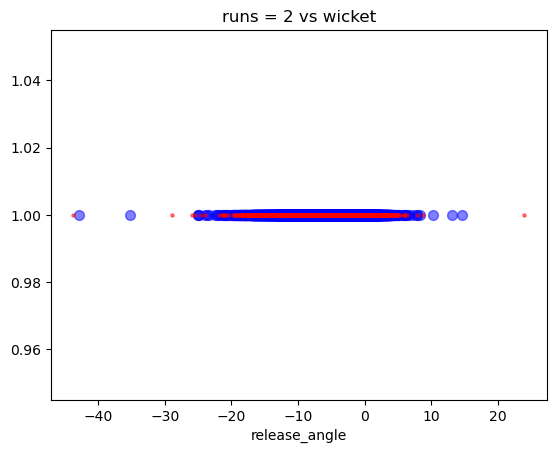

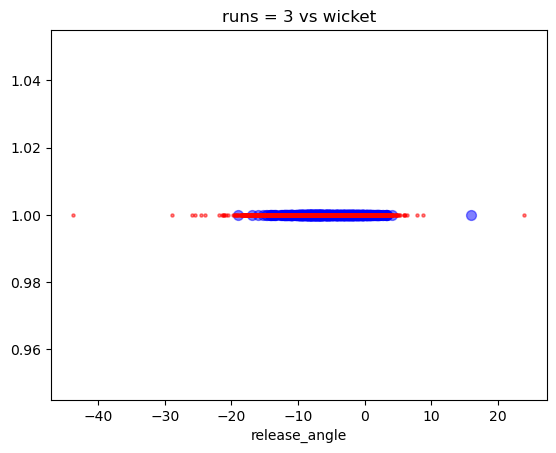

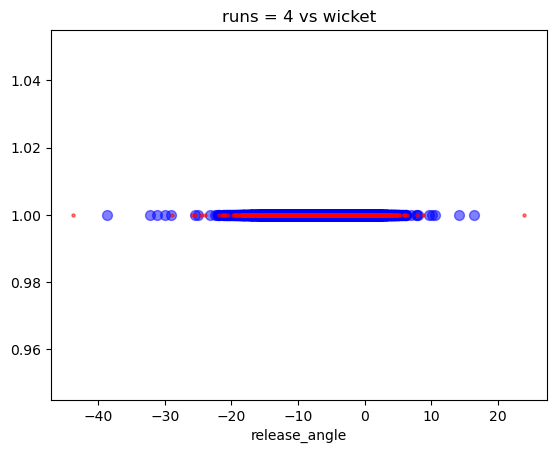

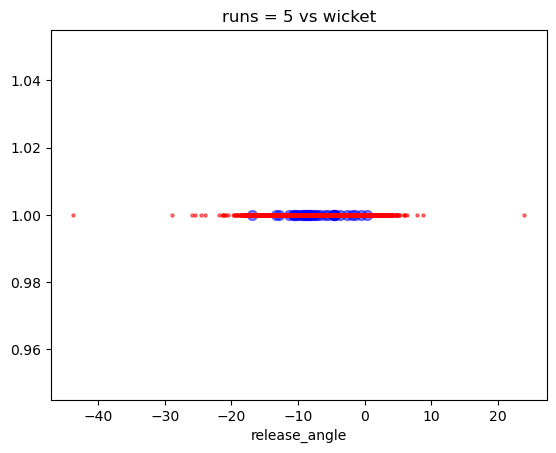

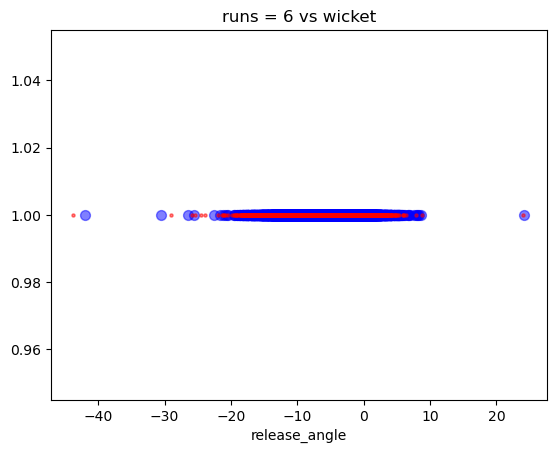

---------------------------------------------------------
drop_angle


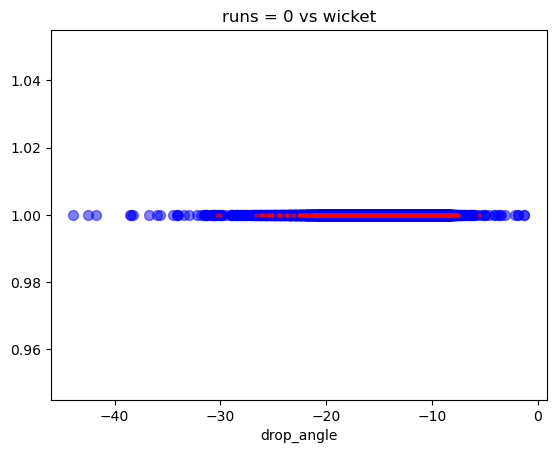

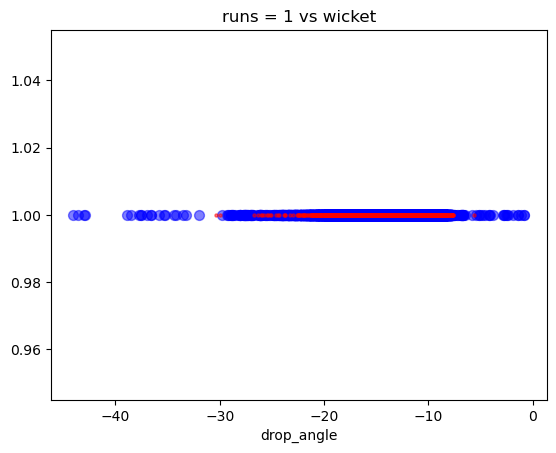

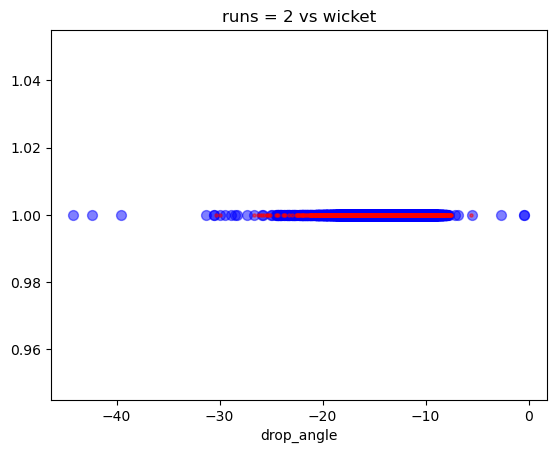

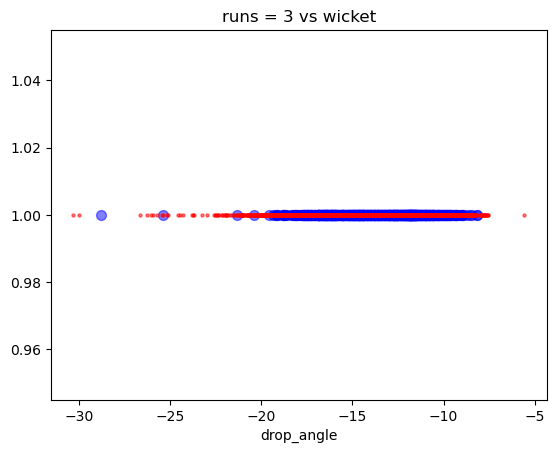

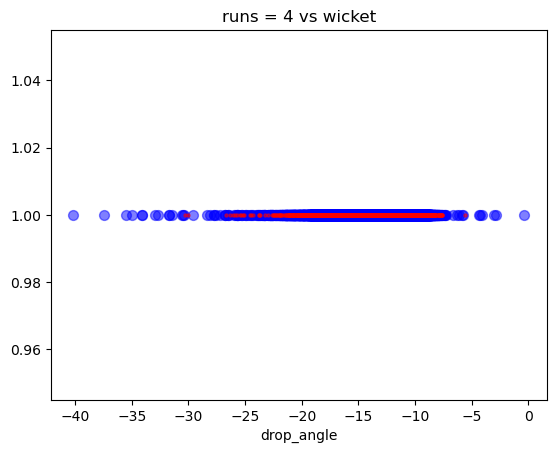

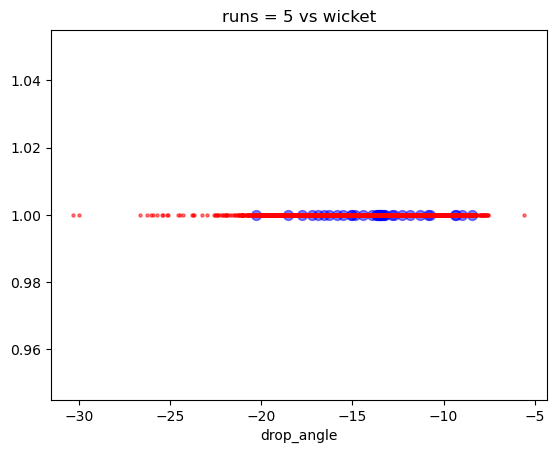

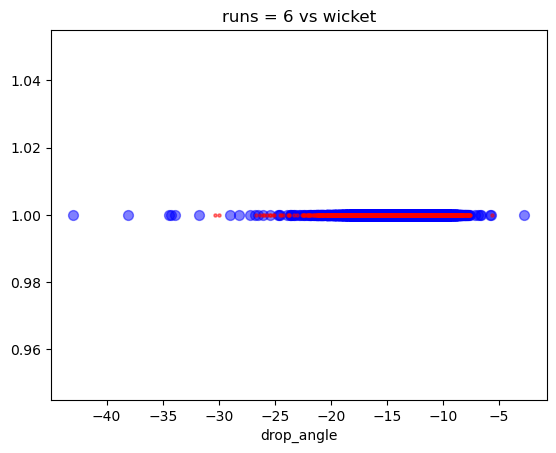

---------------------------------------------------------
crease_position_z


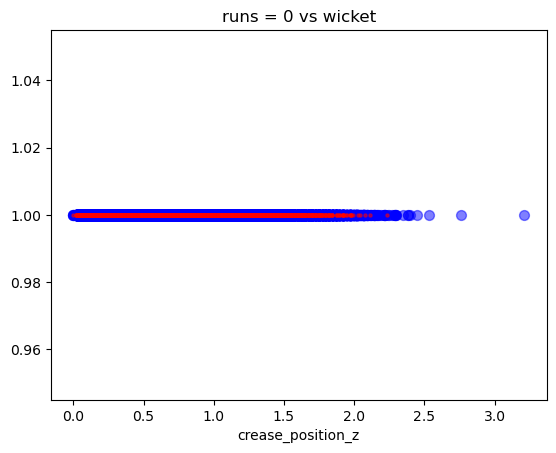

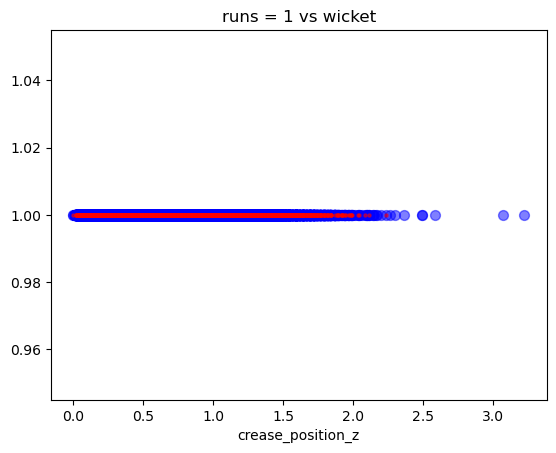

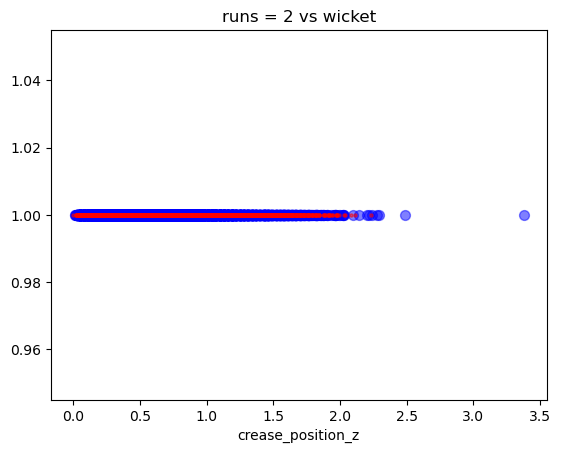

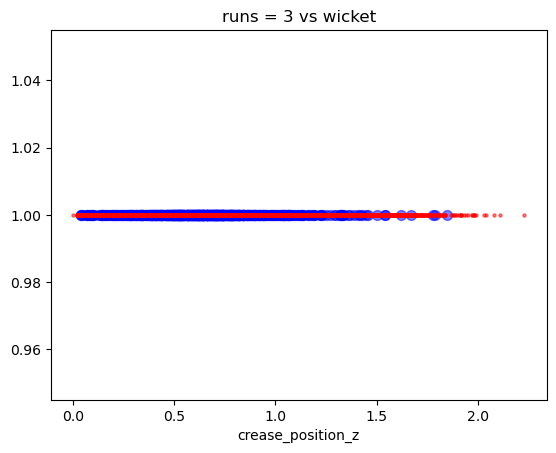

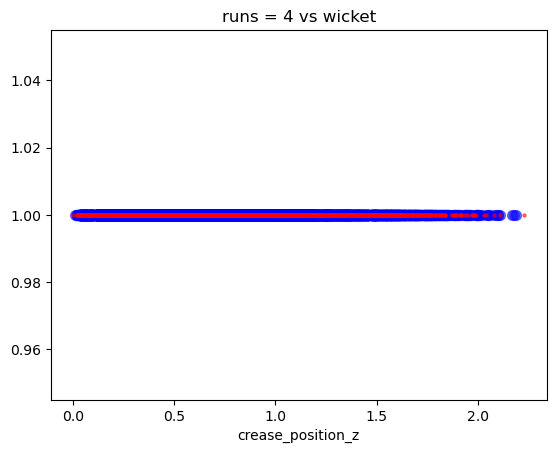

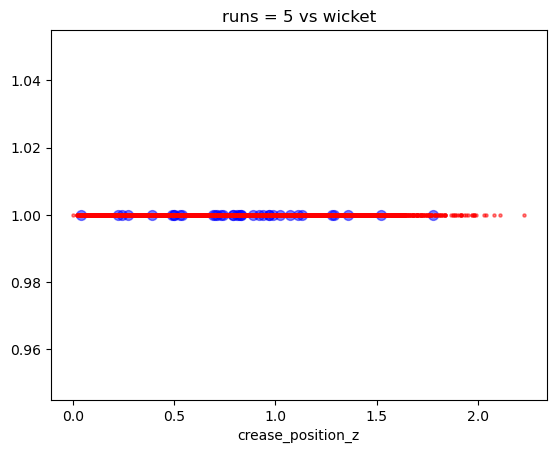

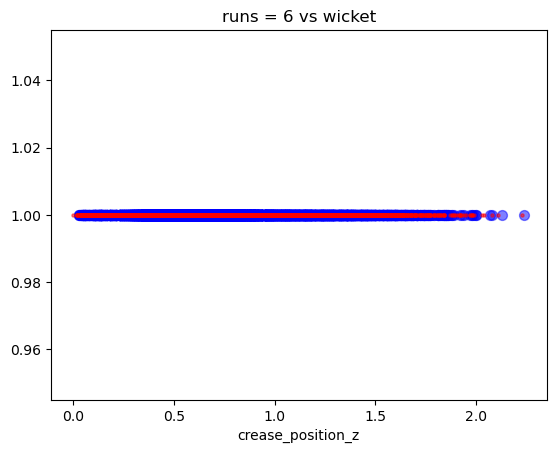

---------------------------------------------------------
crease_position_y


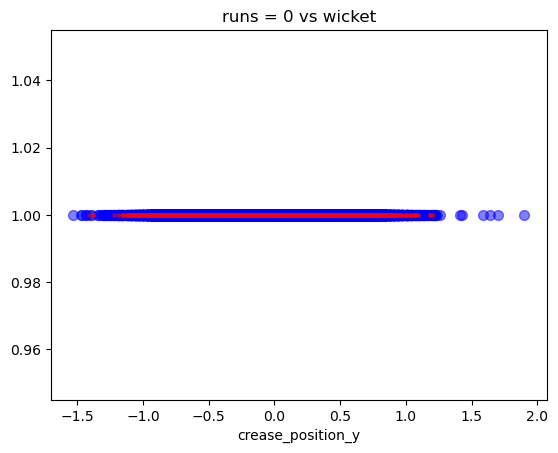

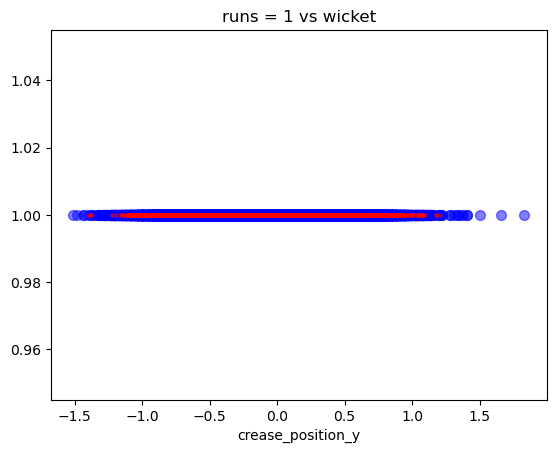

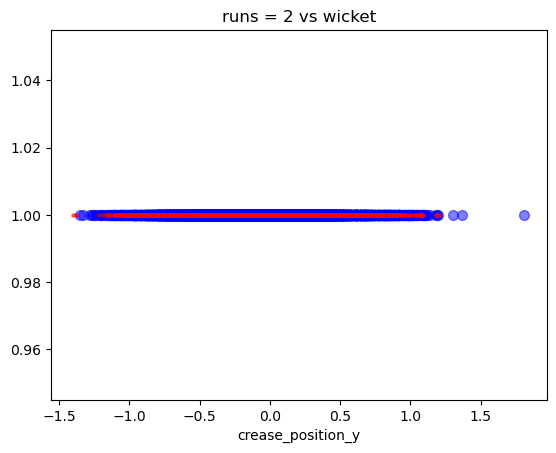

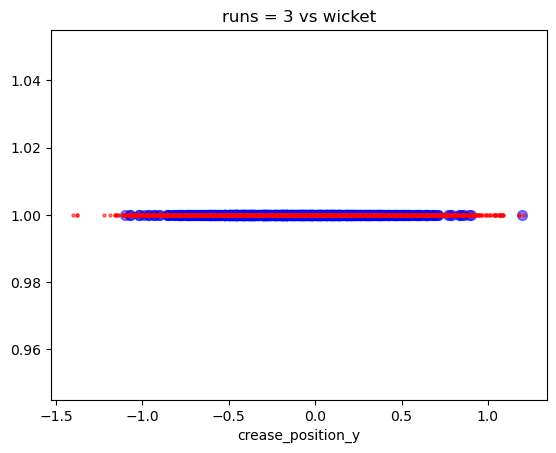

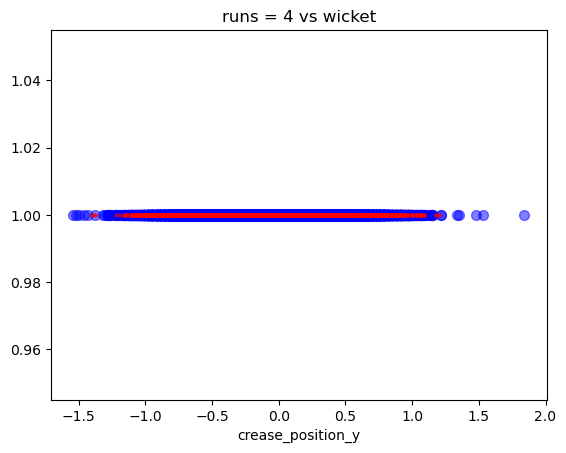

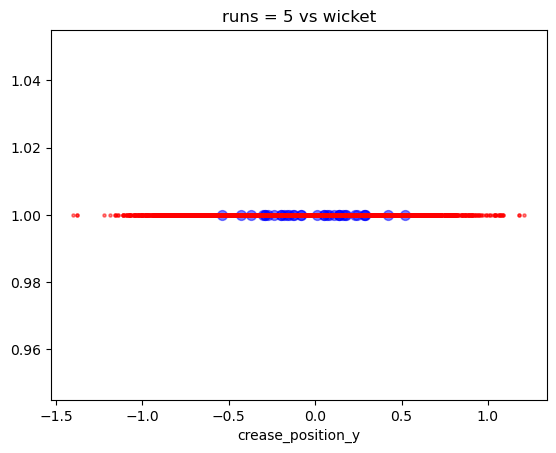

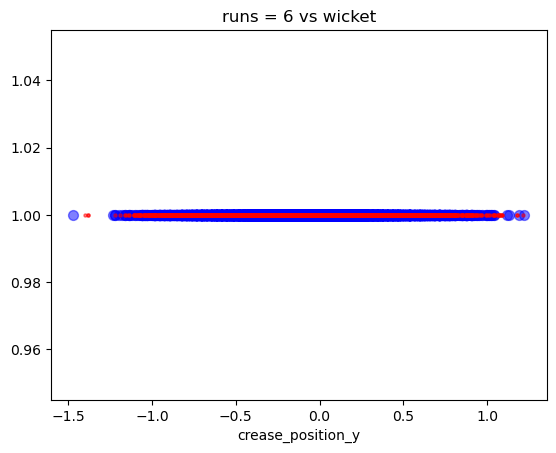

---------------------------------------------------------
bowling_type_spin


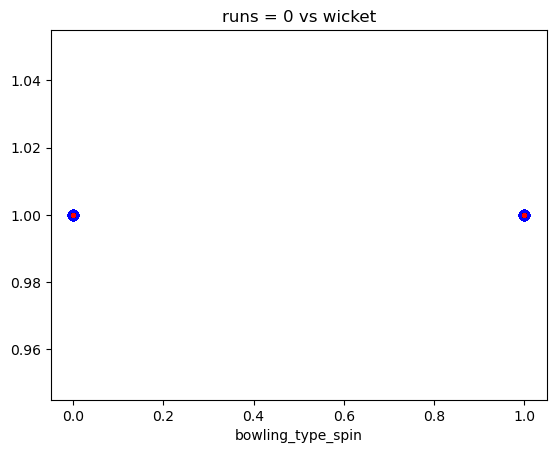

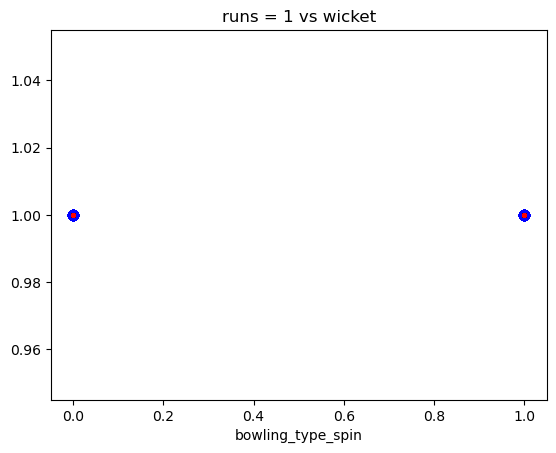

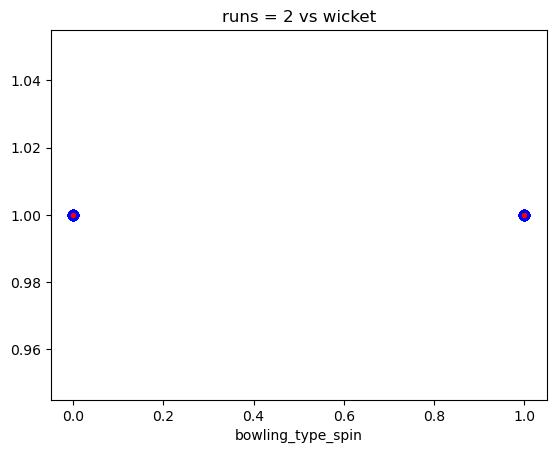

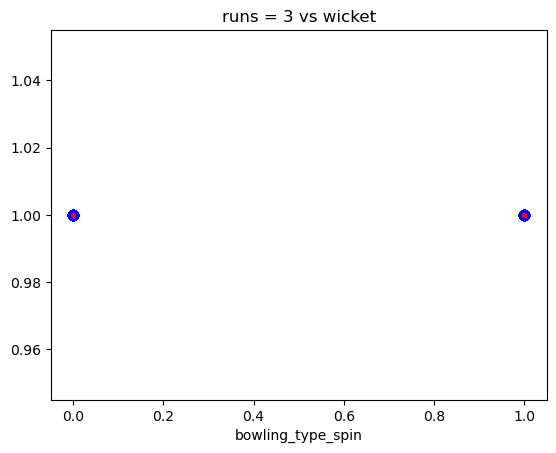

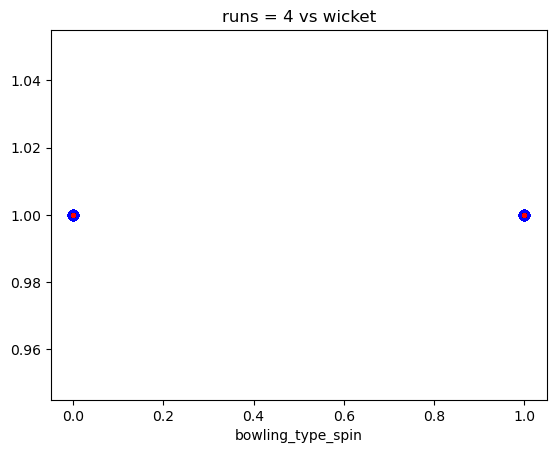

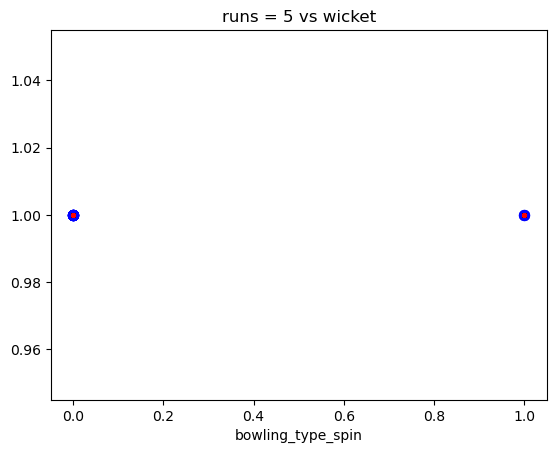

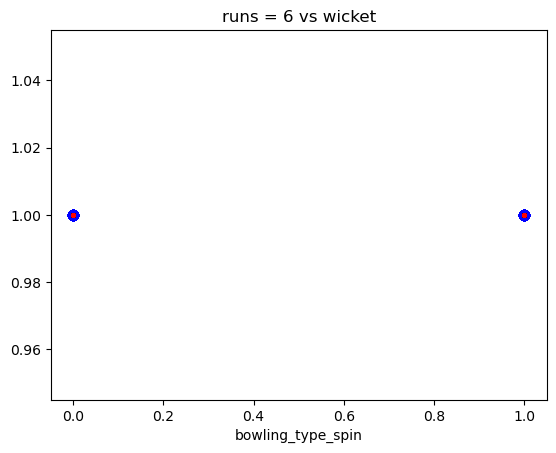

---------------------------------------------------------
bowling_hand_right


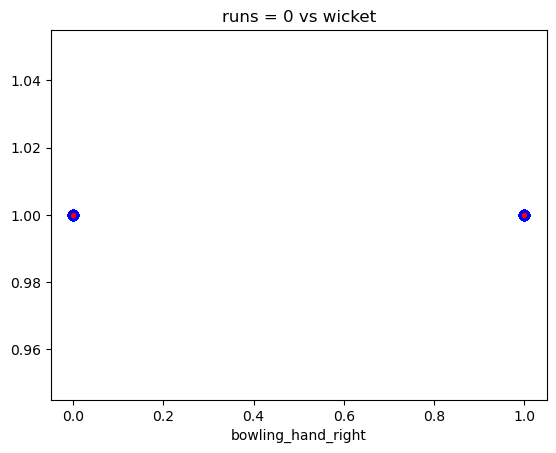

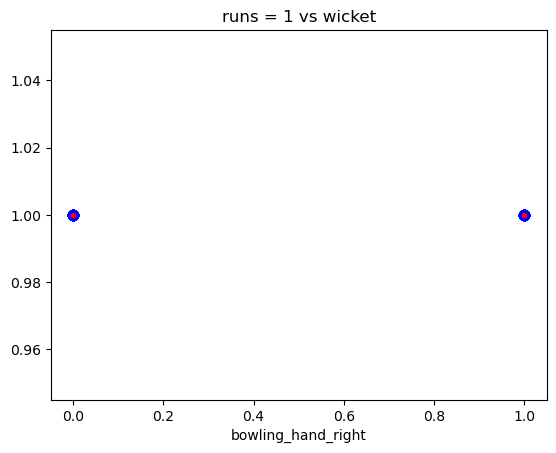

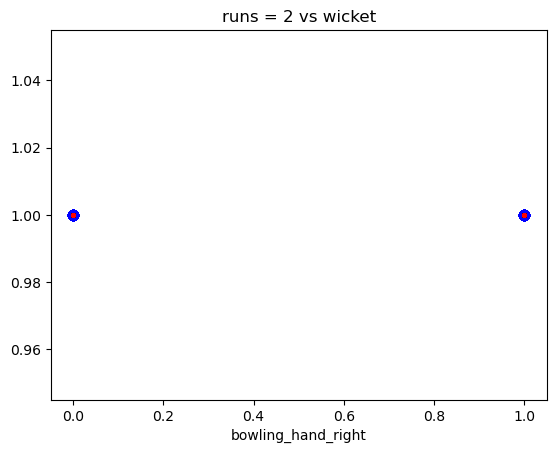

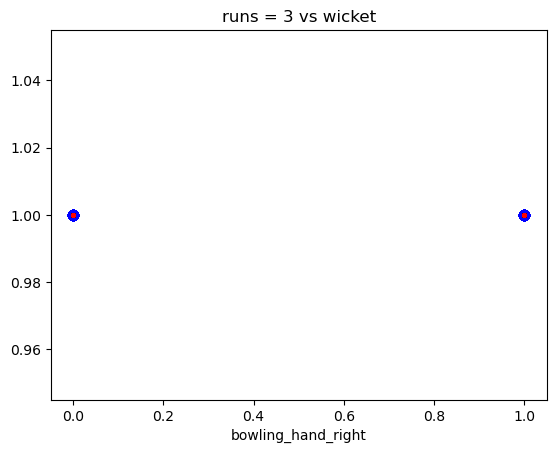

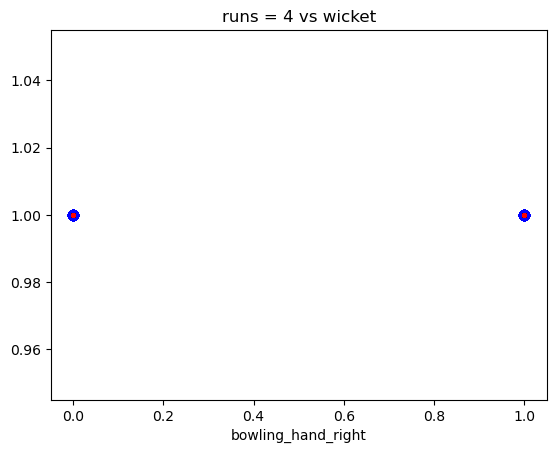

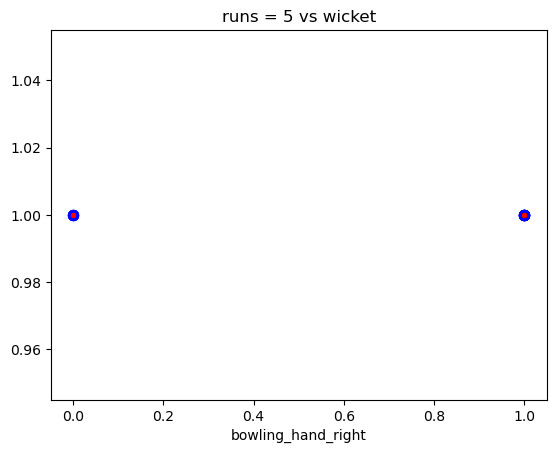

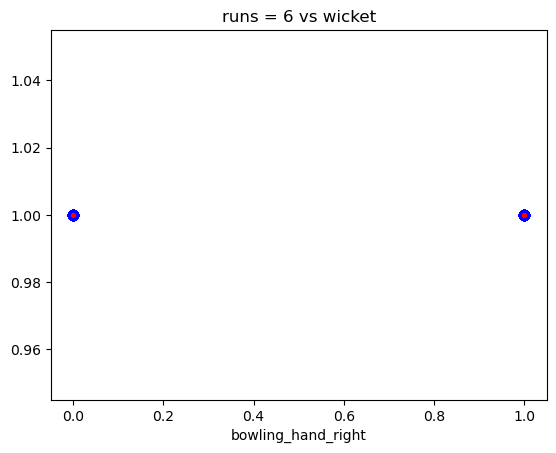

---------------------------------------------------------
bounce_angle


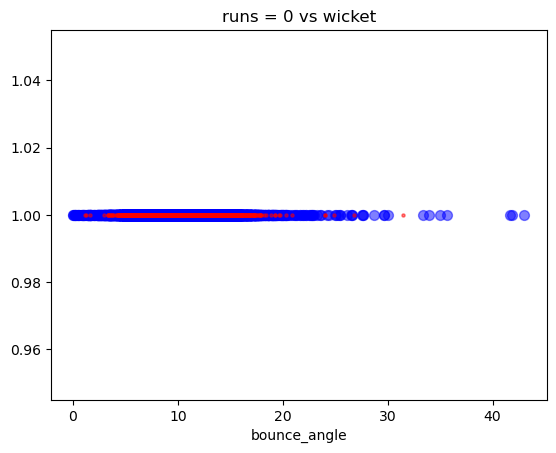

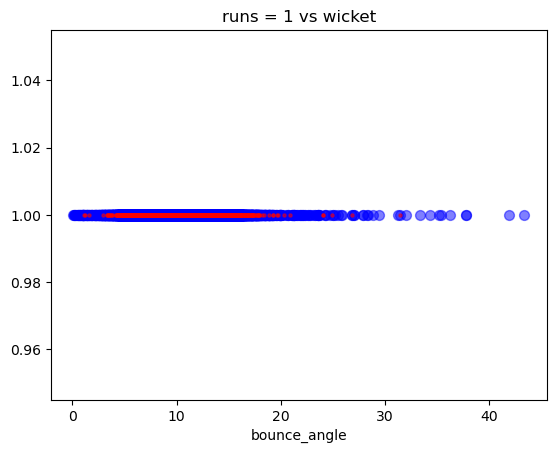

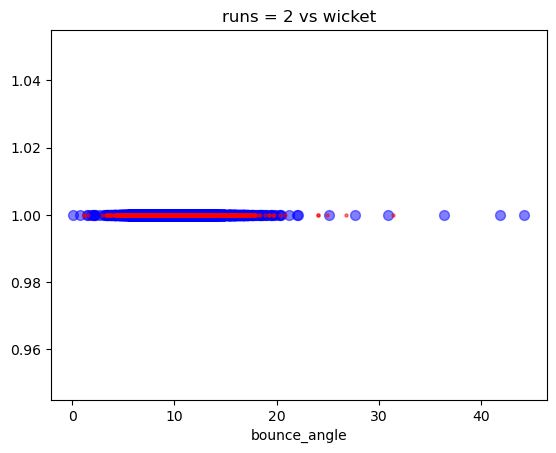

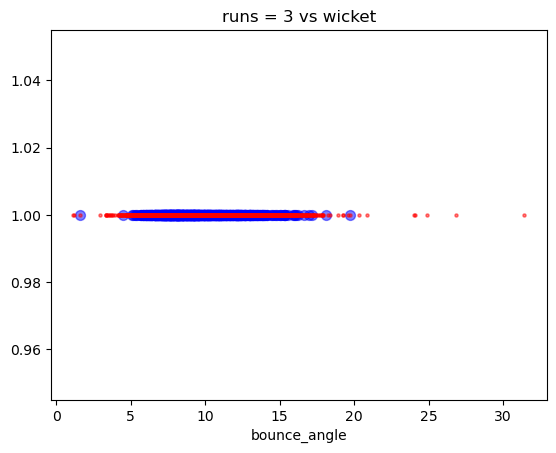

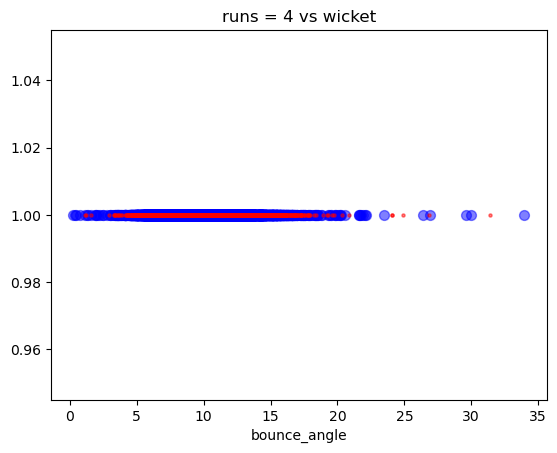

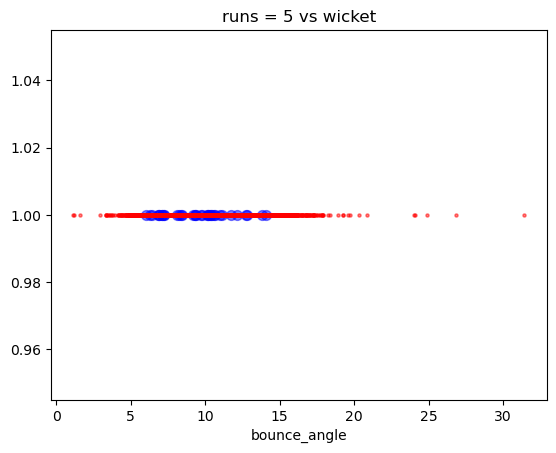

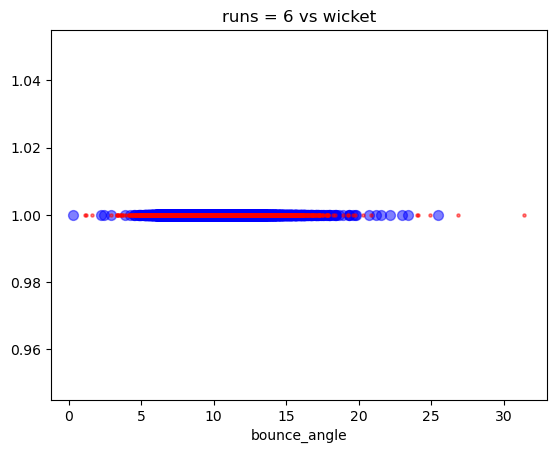

---------------------------------------------------------
batting_hand_right


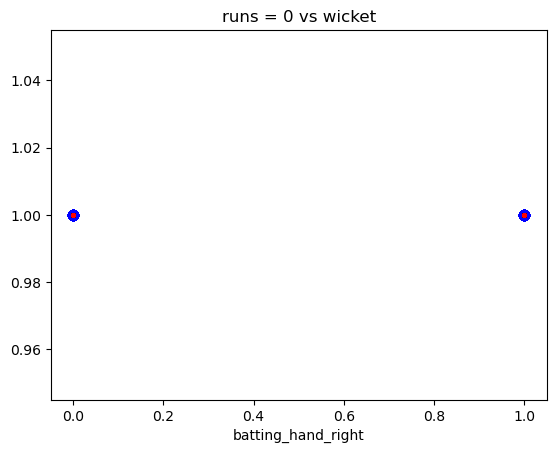

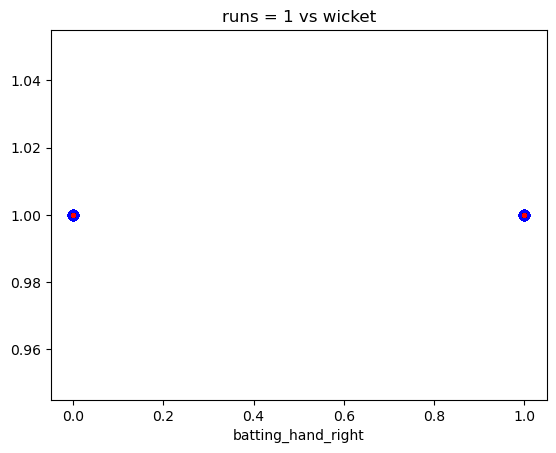

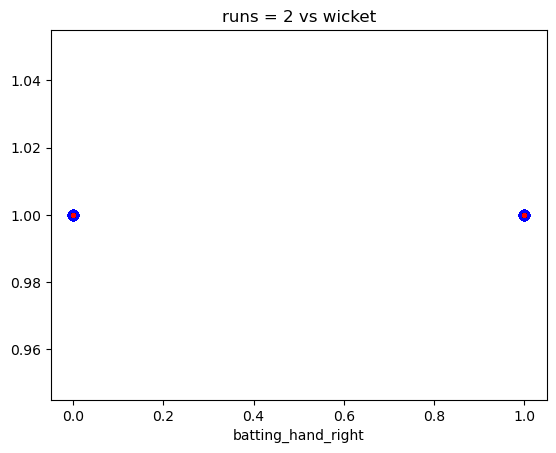

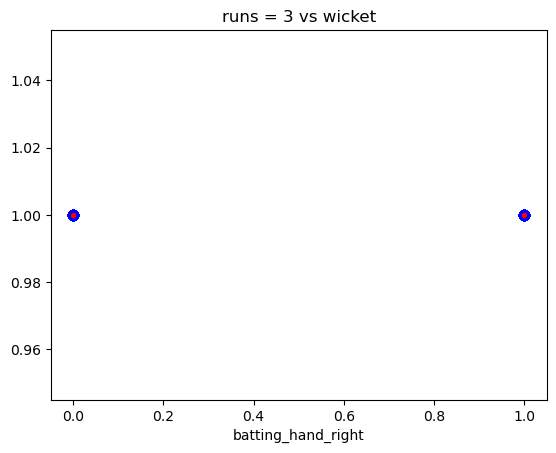

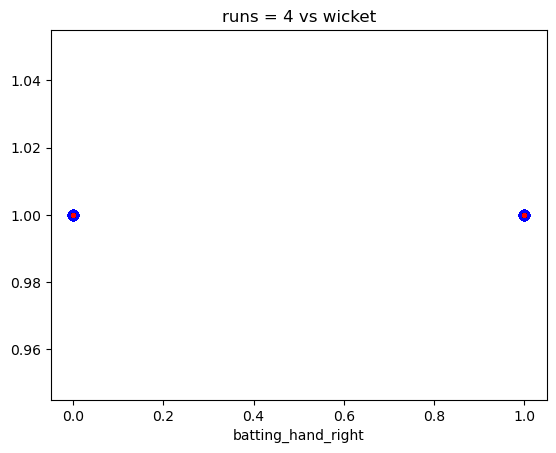

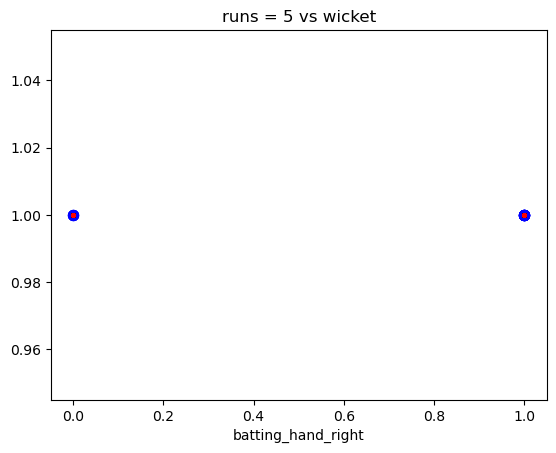

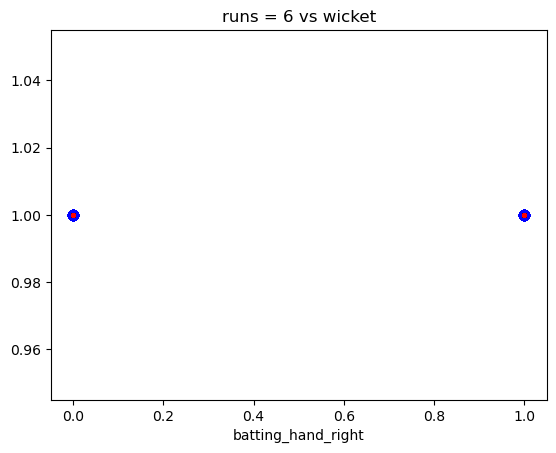

---------------------------------------------------------


In [19]:

# for comb in feature_cols:
for comb in ['swing_angle',
 'deviation',
 'bounce_velocity_ratio_z',
 'bounce_position_x',
 'stumps_position_z',
 'stumps_position_y',
 'bounce_position_y',
 
 'release_speed_kph',
 'release_position_z',
 'release_position_y',
 'release_angle',
 'drop_angle',
 
 'crease_position_z',
 'crease_position_y',
 'bowling_type_spin',
 'bowling_hand_right',


 'bounce_angle',
 'batting_hand_right']:
    col1 = comb
    print(comb)
    for run in sorted(df.query('runs > -1').runs.unique()):
        
        wicket_df= df.query('runs == -1')
        nowicket_df = df.query('runs == @run')
        # cols = [ 'bounce_velocity_ratio_z' , 'stumps_position_z']
        cols = [col1]
        plt.title(f'runs = {run} vs wicket')
        plt.xlabel(cols[0])

        plt.scatter(nowicket_df[cols[0]],np.repeat(1,nowicket_df.shape[0]),color = 'blue',alpha =0.5,s= 50)
        plt.scatter(wicket_df[cols[0]],np.repeat(1,wicket_df.shape[0]),color = 'red',alpha=0.5,s=5)
        plt.show()
    print('---------------------------------------------------------')
        
    
        

### Few more analysis 

In [20]:
df.query('swing_angle < -10 or  swing_angle > 10').runs.value_counts(normalize=True)

runs
 0    0.429825
 1    0.377193
 6    0.061404
 4    0.052632
 2    0.052632
 3    0.017544
-1    0.008772
Name: proportion, dtype: float64

In [21]:
df.query('swing_angle > -10 and  swing_angle < 10').runs.value_counts(normalize=True)

runs
 1    0.393938
 0    0.322623
 4    0.111049
 2    0.067416
 6    0.050927
-1    0.049998
 3    0.003869
 5    0.000180
Name: proportion, dtype: float64

In [22]:
df.query('bounce_velocity_ratio_z >-1.5').runs.value_counts(normalize=True)

runs
 1    0.393884
 0    0.322692
 4    0.111028
 2    0.067403
 6    0.050949
-1    0.049986
 3    0.003879
 5    0.000180
Name: proportion, dtype: float64

['deviation', 'swing_angle']
1


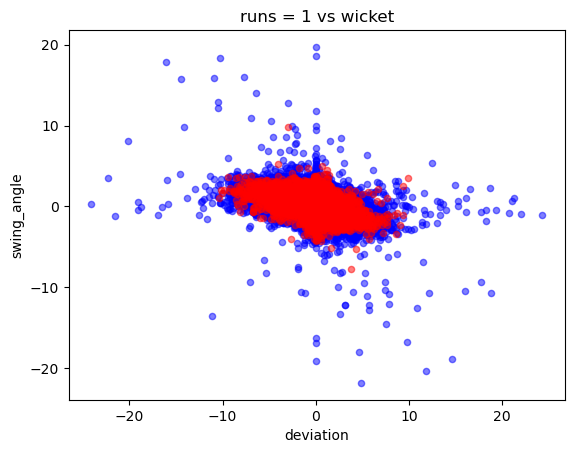

0


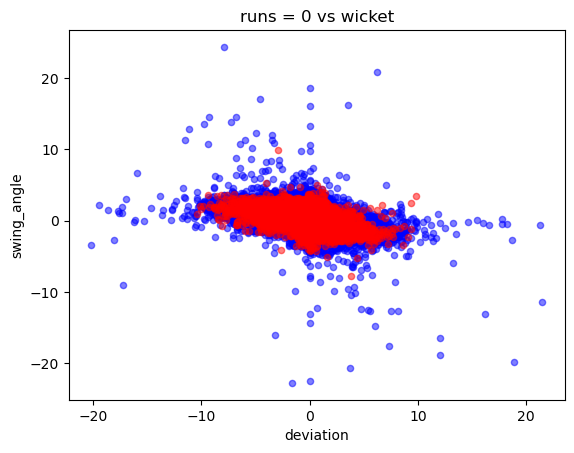

4


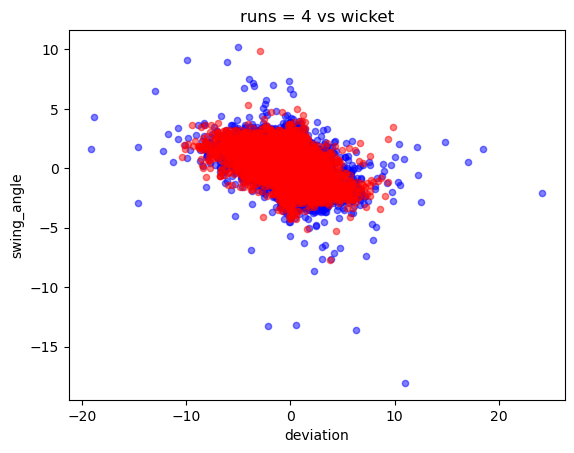

6


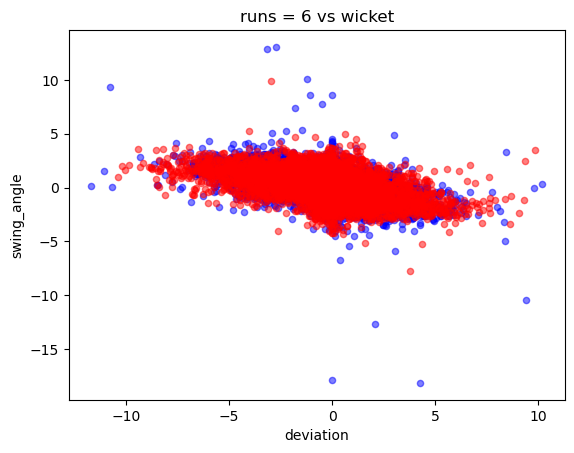

3


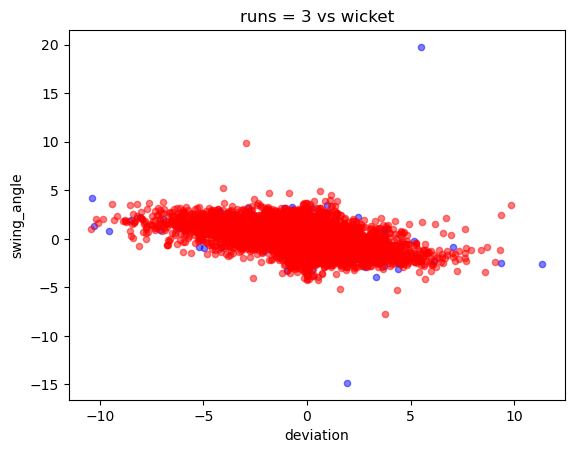

2


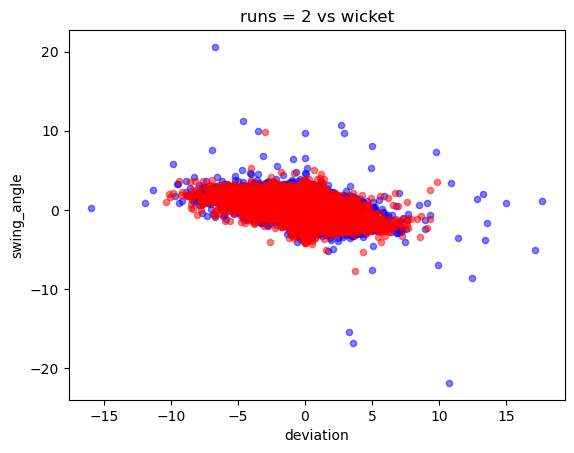

5


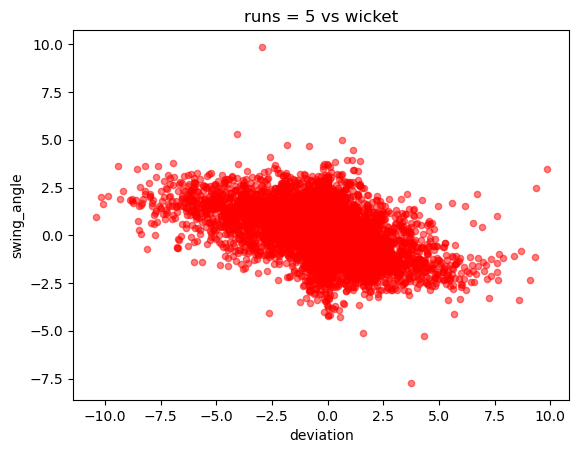

In [23]:
from itertools import combinations

# for comb in combinations(feature_cols,r=2):
for comb in [ ['deviation','swing_angle'] ]:
    col1 = comb[0]
    col2 = comb[1]
    print(comb)
#     df[col1 + "_comb_"+col2]= df[col1]* df[col2]
    for run in df.query('runs > -1').runs.unique():
        print(run)
        wicket_df= df.query('runs == -1')
        nowicket_df = df.query('runs == @run')
        # cols = [ 'bounce_velocity_ratio_z' , 'stumps_position_z']
        cols = [col1,col2]
        plt.title(f'runs = {run} vs wicket')
        plt.xlabel(cols[0])
        plt.ylabel(cols[1])
        plt.scatter(nowicket_df[cols[0]],nowicket_df[cols[1]],color = 'blue',alpha =0.5,s= 20)
        plt.scatter(wicket_df[cols[0]],wicket_df[cols[1]],color = 'red',alpha=0.5,s=20)
        plt.show()
        
    


Text(0, 0.5, 'bounce_position_x')

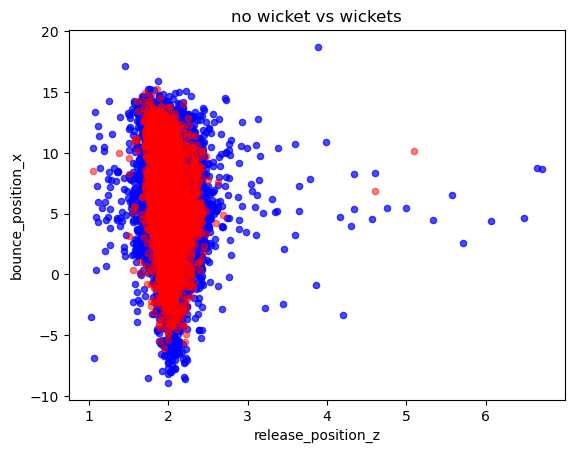

In [24]:
wicket_df= df.query('runs == -1')
nowicket_df = df.query('runs == 0')
# cols = [ 'bounce_velocity_ratio_z' , 'stumps_position_z']
cols = ['release_position_z','bounce_position_x']
plt.scatter(nowicket_df[cols[0]],nowicket_df[cols[1]],color = 'blue',alpha =0.7,s= 20)
plt.scatter(wicket_df[cols[0]],wicket_df[cols[1]],color = 'red',alpha=0.5,s=20)
plt.title('no wicket vs wickets')
plt.xlabel(cols[0])
plt.ylabel(cols[1])

## Reasoning behind Linear/Logistic Regression's poor performance

- As we see above the wickets cluster is embedded inside the non-wickets clusters which means the clusters are not linearly separable. 
- So may be the __interaction terms ( combined effect of multiple features)__ might help
- Or __Support Vector Machines__ might help since they might separate clusters in __infinite dimensions__ for example

### Decision Trees might be a suitable model here since the data of the domain is such that the 

- Wickets falling down is a rare event
- Most of the balls are scored for ones or dots
- 3's and 5's are extremely rare
- 4's and 6's are decently proportional compared to the wickets
- A lot of edges and misses are also part of the game.
- So everytime a similar delivery is bowled , there is no directly discriminating feature which will definitively indicate a wicket unless we incorporate other context such as  batsman skill or field placements or batting position or overs or chasing/setting target. 
- The decision tree __feature importance__ shows that __bounce_position_x__ (Length of ball) plays an important role 
- A decision tree should be able to give the probability distribution of wickets, runs =0,1,2,3,4,5 in a given node
- A good measure is to evalaute the prob distribution using brier skill score or ignorance score as discussed further below

#### Interaction variables construction.
- COmmented for now as model training is consuming time
- However I have observed a positive change with regression models with interaction variables but not with Ensembe methods

In [25]:
# from itertools import combinations

# for comb in combinations(feature_cols,r=2):
#     col1 = comb[0]
#     col2 = comb[1]
#     df.loc[:,col1 + "_comb_"+col2]= df[col1]* df[col2]


In [26]:
# feature_cols = df.columns[~df.columns.isin(target_cols)].tolist()

### Discretized Bins.
- I realized that discretizing the variables into quantile bins or equal bins might help in discriminating different categories of out come
- I haven't used them in the model since models might have more variables  

In [27]:
pd.cut(df['bounce_velocity_ratio_z'],bins=10,labels=None,duplicates='drop').cat.categories

IntervalIndex([(-2.883, -2.592], (-2.592, -2.304], (-2.304, -2.016], (-2.016, -1.728], (-1.728, -1.44], (-1.44, -1.152], (-1.152, -0.864], (-0.864, -0.576], (-0.576, -0.288], (-0.288, 0.0]], dtype='interval[float64, right]')

In [28]:
# df['bvr_bins'] = pd.cut(df['bounce_velocity_ratio_z'],bins=10,labels=None,duplicates='drop')

 
df.query('runs == -1').bvr_bins.value_counts(normalize = True)

bvr_bins
(-0.864, -0.576]    0.710505
(-0.576, -0.288]    0.286099
(-1.152, -0.864]    0.002497
(-0.288, 0.0]       0.000499
(-1.44, -1.152]     0.000300
(-2.304, -2.016]    0.000100
(-2.883, -2.592]    0.000000
(-2.592, -2.304]    0.000000
(-2.016, -1.728]    0.000000
(-1.728, -1.44]     0.000000
Name: proportion, dtype: float64

## Correlation Matrix
Hardly correlated with target variable runs (even when discretized) indicating a hard problem to solve with ML

In [29]:
num_cols_df = df.select_dtypes(include= ['float','int','boolean'])

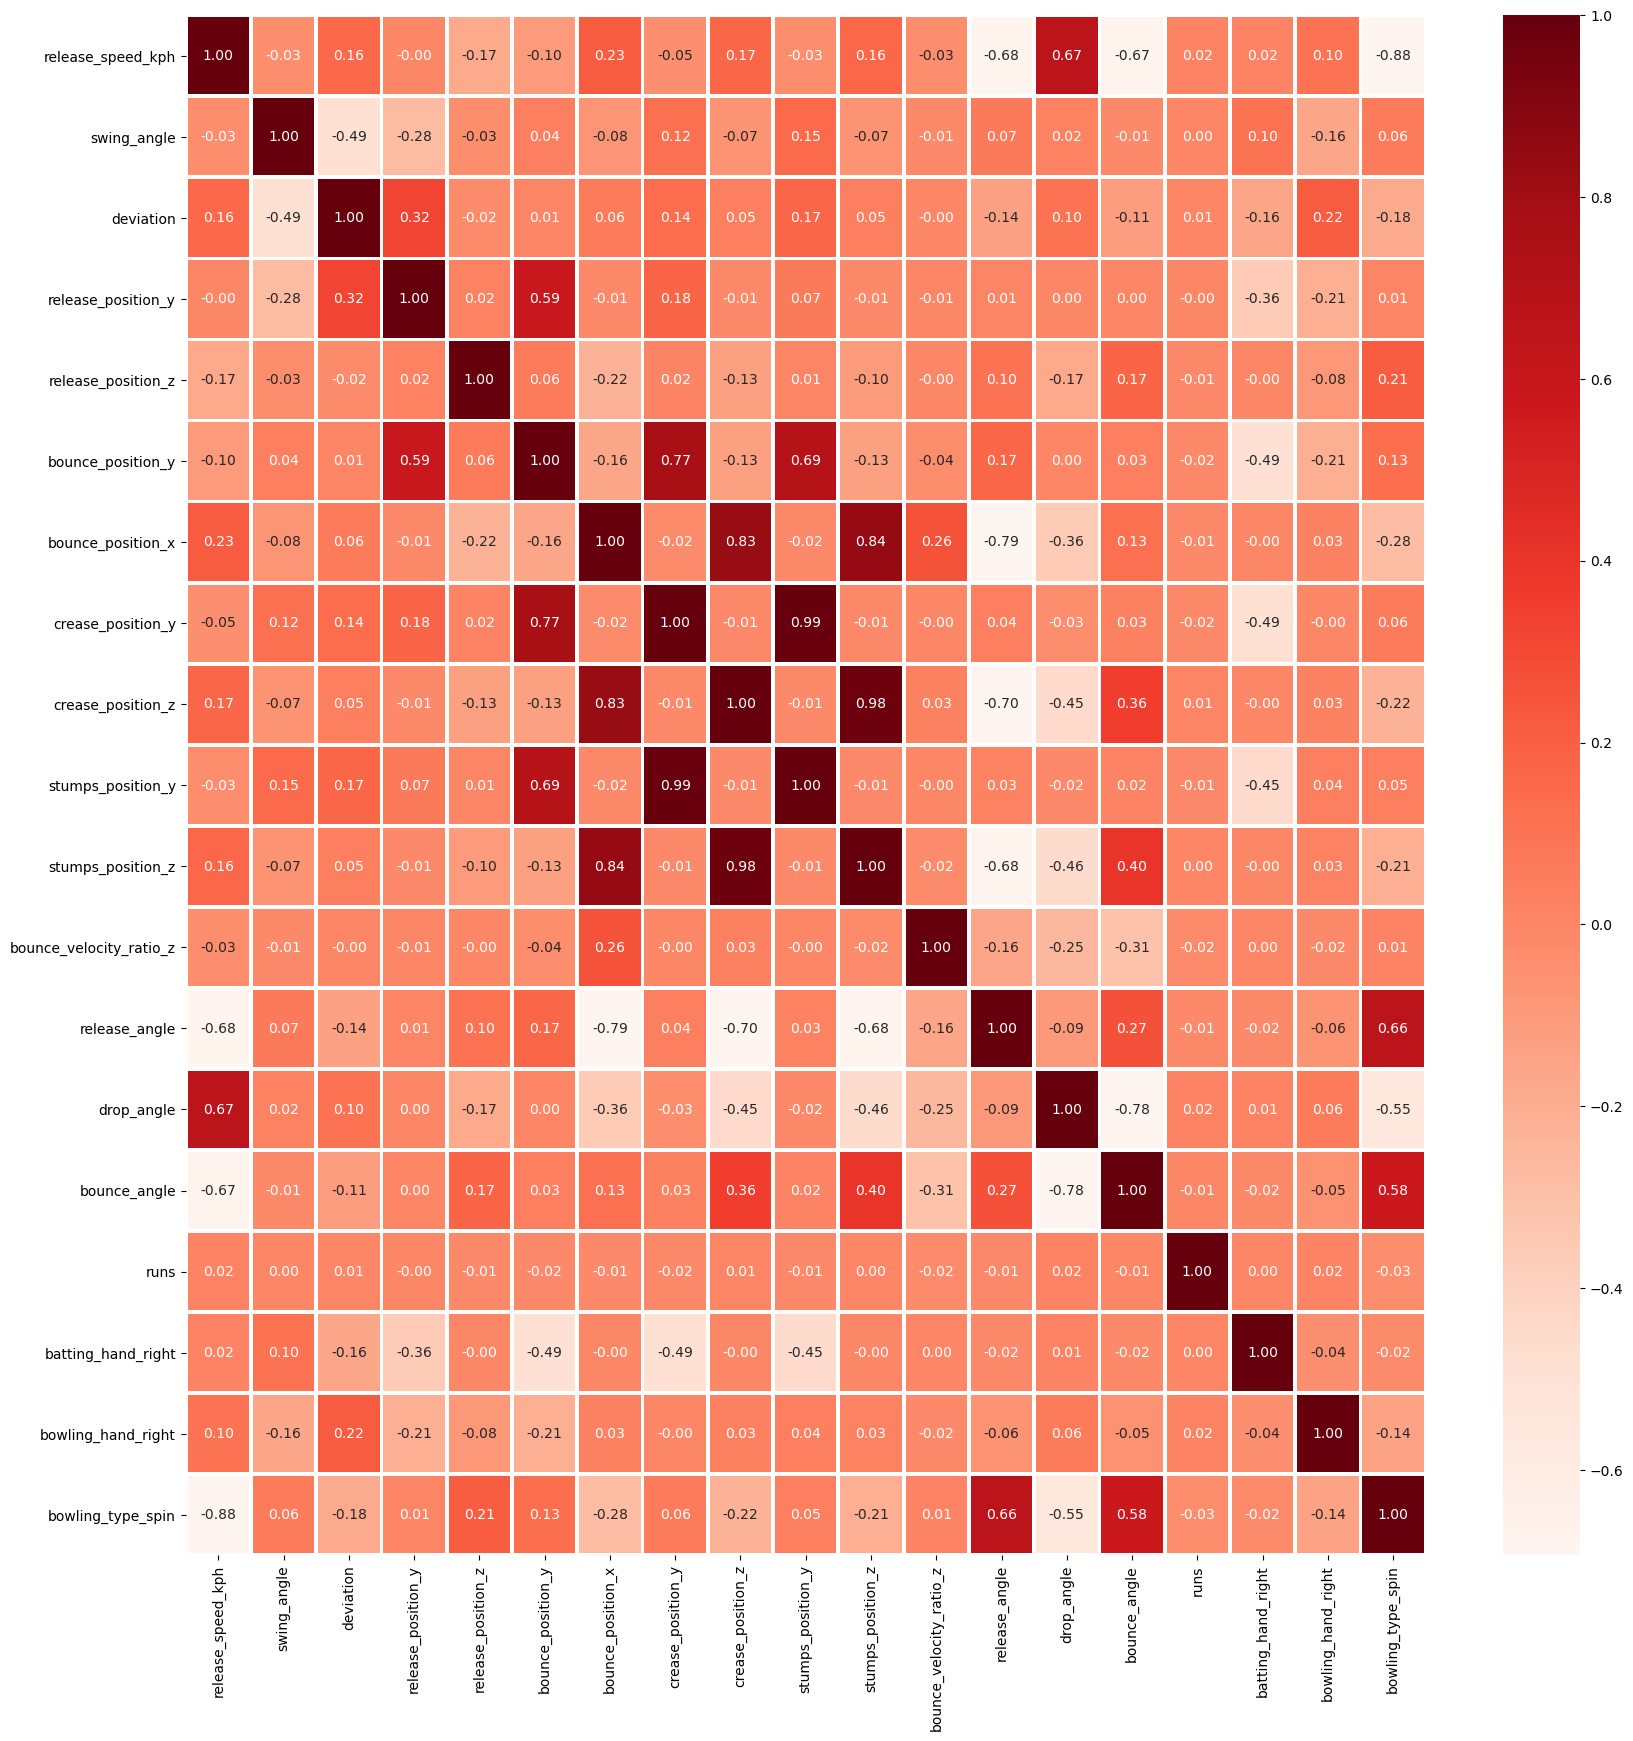

In [30]:
fig,ax = plt.subplots(figsize=(20,20))  
sn.heatmap(num_cols_df.corr(method="pearson"),ax=ax,annot=True,cmap='Reds',fmt='3.2f',linewidths=2,robust=True,square=False)
plt.show()

### Histogram for each runs category with other

In [31]:

# for col in df[feature_cols].select_dtypes(include = ['float','int']).columns:
#     print(col)
#     temp1 = df.query('runs == "wicket"')
#     weights1= np.ones_like(temp1) / len(temp1)
#     temp1[col].plot(kind='hist',color='red',alpha=0.7,weights= weights1 )#,weights= weights1
    
#     temp2 = df.query('runs != "wicket" ')
#     weights2= np.ones_like(temp2) / len(temp2)
    
#     temp2[col].plot(kind='hist',color='blue',alpha=0.5,weights=weights2) #weights=weights2
    
# #     weights3= np.ones_like(df) / len(df)
# #     df[col].plot(kind='hist',color='orange',alpha=0.33 ,weights=weights3)
#     plt.show()

In [32]:
df.query('release_speed_kph > 130 and release_speed_kph < 145   ').runs.value_counts(normalize=True)

runs
 0    0.357819
 1    0.341273
 4    0.138056
 2    0.064936
-1    0.050263
 6    0.042591
 3    0.004837
 5    0.000224
Name: proportion, dtype: float64

In [33]:
df.release_speed_kph.value_counts(normalize=True,ascending=False)

release_speed_kph
132.77    0.000679
132.45    0.000649
130.36    0.000634
129.39    0.000629
129.71    0.000624
            ...   
63.47     0.000005
64.56     0.000005
53.85     0.000005
153.38    0.000005
157.17    0.000005
Name: proportion, Length: 8172, dtype: float64

In [34]:
pd.qcut(df['release_speed_kph'],q=10,labels=False,duplicates='drop').value_counts(normalize=False,ascending=False)

release_speed_kph
1.0    20047
7.0    20038
4.0    20031
5.0    20029
0.0    20027
6.0    20027
2.0    20017
8.0    20017
3.0    19998
9.0    19991
Name: count, dtype: int64

In [35]:
pd.qcut(df['release_speed_kph'],q=20,labels=None).dtype

CategoricalDtype(categories=[(40.199000000000005, 81.58], (81.58, 84.34], (84.34, 86.5], (86.5, 88.58], (88.58, 90.8] ... (132.84, 134.62], (134.62, 136.44], (136.44, 138.56], (138.56, 141.38], (141.38, 168.67]], ordered=True)

In [36]:
pd.cut(df['release_speed_kph'],bins=10,labels=None,duplicates='drop').cat.categories

IntervalIndex([(40.072, 53.047], (53.047, 65.894], (65.894, 78.741], (78.741, 91.588], (91.588, 104.435], (104.435, 117.282], (117.282, 130.129], (130.129, 142.976], (142.976, 155.823], (155.823, 168.67]], dtype='interval[float64, right]')

In [37]:
pd.cut(df['swing_angle'],bins=20,labels=None,duplicates='drop').cat.categories

IntervalIndex([(-24.549, -22.057], (-22.057, -19.614], (-19.614, -17.171], (-17.171, -14.728], (-14.728, -12.285] ... (12.145, 14.588], (14.588, 17.031], (17.031, 19.474], (19.474, 21.917], (21.917, 24.36]], dtype='interval[float64, right]')

In [38]:
pd.cut(df['deviation'],bins=10,labels=None,duplicates='drop').cat.categories

IntervalIndex([(-24.128, -19.243], (-19.243, -14.406], (-14.406, -9.569], (-9.569, -4.732], (-4.732, 0.105], (0.105, 4.942], (4.942, 9.779], (9.779, 14.616], (14.616, 19.453], (19.453, 24.29]], dtype='interval[float64, right]')

In [39]:
df.query('release_speed_kph > 130 and  release_speed_kph < 140').shape

(50795, 19)

In [40]:
df.query('swing_angle > -2.5 and swing_angle < 2.5  ').runs.value_counts(normalize=False)

runs
 1    75891
 0    61561
 4    21417
 2    13001
 6     9813
-1     9642
 3      746
 5       36
Name: count, dtype: int64

In [41]:
df.query('bounce_velocity_ratio_z < -0.75 or bounce_velocity_ratio_z > -0.5 ').runs.value_counts(normalize=True)

runs
 1    0.383091
 0    0.373714
 4    0.093466
 2    0.063218
-1    0.054749
 6    0.028509
 3    0.003025
 5    0.000227
Name: proportion, dtype: float64

## Modeling

In [42]:
def get_modeling_data_sets(df,split_size=0.25,standardize_feat=False):
    train = df.dropna()
    
    train.loc[:,'runs']  = train.runs.replace(-1,'wicket')
    train.loc[:,'runs'] = train.runs.replace(0,'dot')
    train.loc[:,'runs']= train.runs.replace(1,'single')
    train.loc[:,'runs'] = train.runs.replace(2,'double')
    train.loc[:,'runs'] = train.runs.replace(3,'triple')
    train.loc[:,'runs'] = train.runs.replace(4,'four')
    train.loc[:,'runs'] = train.runs.replace(5,'five')
    train.loc[:,'runs'] = train.runs.replace(6,'six')
    
    trainx = train.drop('runs',axis=1)
    trainy = train.runs
    


    train_test_df=train_test_split(trainx,trainy,test_size=0.25,random_state=42,shuffle=True)
    train_x_df=train_test_df[0]
    test_x_df=train_test_df[1]
    train_y_df=train_test_df[2]
    test_y_df=train_test_df[3]
   

    if standardize_feat:
        num_feat_cols_df = trainx[feature_cols].select_dtypes(include = ['float','int'])
        ss = StandardScaler()

        train_x_df.loc[:,num_feat_cols_df.columns] = ss.fit_transform(train_x_df[num_feat_cols_df.columns])
        test_x_df.loc[:,num_feat_cols_df.columns] = ss.transform(test_x_df[num_feat_cols_df.columns])

    for col in ['batting_hand_right',
       'bowling_hand_right', 'bowling_type_spin']:
        
        train_x_df = train_x_df.astype({col:'int'})
        test_x_df = test_x_df.astype({col:'int'})
    print(f"{train_x_df.shape} {test_x_df.shape} {train_y_df.shape} {test_y_df.shape} ")
    return train_x_df,test_x_df,train_y_df,test_y_df

In [43]:
def get_test_results(pred_y_labels,pred_y_probs,test_x_df,classnames):
    res1_df = pd.DataFrame(pred_y_labels,index=test_x_df.index,columns=['pred_label'])
    res3_df = pd.DataFrame(pred_y_probs,index=test_x_df.index,columns=classnames)
    return pd.concat([test_x_df,pd.DataFrame(test_y_df),res1_df,res3_df],axis = 1)
    

In [44]:
train_x_df,test_x_df,train_y_df,test_y_df = get_modeling_data_sets(df,standardize_feat=True)

(145701, 18) (48568, 18) (145701,) (48568,) 


In [45]:
mlogit_mod = sm.MNLogit(train_y_df, sm.add_constant(train_x_df[feature_cols]))
mlogit_res = mlogit_mod.fit()
print(mlogit_res.params)

Optimization terminated successfully.
         Current function value: 1.465689
         Iterations 12
                                0         1         2         3         4   
const                   -1.492799 -7.725684 -0.913030  0.214112 -1.655281  \
release_speed_kph       -0.446031 -0.846524 -0.043651 -0.506180 -0.517788   
swing_angle              0.012937  0.112016  0.014156  0.021456  0.037648   
deviation               -0.030558  0.689512  0.006988  0.003521 -0.007431   
release_position_y       0.036789 -1.454969  0.023087 -0.000248  0.042159   
release_position_z      -0.082944 -0.383589 -0.081556 -0.069902 -0.107433   
bounce_position_y       -0.040397  0.567119  0.005734 -0.002927 -0.082398   
bounce_position_x       -0.338190  0.046592 -0.282569 -0.178345 -0.440721   
crease_position_y       -0.312112  6.921458 -0.361998 -0.136130 -0.126443   
crease_position_z        0.330273 -0.438640  0.390366  0.244326  0.499332   
stumps_position_y        0.371248 -6.848598  0.293

In [46]:
mlogit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                   runs   No. Observations:               145701
Model:                        MNLogit   Df Residuals:                   145568
Method:                           MLE   Df Model:                          126
Date:                Mon, 03 Feb 2025   Pseudo R-squ.:                 0.01074
Time:                        14:49:42   Log-Likelihood:            -2.1355e+05
converged:                       True   LL-Null:                   -2.1587e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================
            runs=double       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.4928      0.038    -39.407      0.000      -1.567      -1.419
release_speed_kph          -0.4460      0.038    -11.810      0.000      -0.520      -0.372
swing_angle                 0.0129      0.020      0.639      0.523      -0.027       0.053
deviation                  -0.0306      0.047     -0.655      0.512      -0.122       0.061
release_position_y          0.0368      0.070      0.527      0.598      -0.100       0.174
release_position_z         -0.0829      0.014     -5.808      0.000      -0.111      -0.055
bounce_position_y          -0.0404      0.033     -1.214      0.225      -0.106       0.025
bounce_position_x          -0.3382      0.038     -8.939      0.000      -0.412      -0.264
crease_position_y          -0.3121      0.520     -0.601      0.548      -1.330       0.706
crease_position_z           0.3303      0.065      5.079      0.000       0.203       0.458
stumps_position_y           0.3712      0.519      0.715      0.475      -0.646       1.389
stumps_position_z          -0.6174      0.069     -8.895      0.000      -0.753      -0.481
bounce_velocity_ratio_z    -0.0409      0.023     -1.808      0.071      -0.085       0.003
release_angle              -0.5092      0.045    -11.328      0.000      -0.597      -0.421
drop_angle                 -0.0213      0.038     -0.553      0.580      -0.097       0.054
bounce_angle                0.1917      0.038      5.111      0.000       0.118       0.265
batting_hand_right          0.1348      0.030      4.520      0.000       0.076       0.193
bowling_hand_right          0.1255      0.028      4.493      0.000       0.071       0.180
bowling_type_spin          -0.7332      0.050    -14.771      0.000      -0.830      -0.636
-------------------------------------------------------------------------------------------
              runs=five       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -7.7257      0.697    -11.083      0.000      -9.092      -6.359
release_speed_kph          -0.8465      0.597     -1.418      0.156      -2.016       0.323
swing_angle                 0.1120      0.221      0.506      0.613      -0.322       0.546
deviation                   0.6895      0.395      1.744      0.081      -0.085       1.464
release_position_y         -1.4550      0.708     -2.055      0.040      -2.843      -0.067
release_position_z         -0.3836      0.241     -1.593      0.111      -0.856       0.088
bounce_position_y           0.5671      0.591      0.960      0.337      -0.591       1.725
bounce_position_x           0.0466      0.644      0.072      0.942      -1.217       1.310
crease_position_y           6.9215      5.333      1.298      0.194      -3.531      17.374
crease_position_z          -0.4386      1.470     -0.298      0.765      -3.320       2.443
stumps_position_y    

In [47]:
# margeff = mlogit_res.get_margeff()
# margeff.summary()


In [48]:
mlogit_res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: MNLogit
=========================================================================
Model:                 MNLogit            Method:             MLE        
Dependent Variable:    runs               Pseudo R-squared:   0.011      
Date:                  2025-02-03 14:49   AIC:                427370.8252
No. Observations:      145701             BIC:                428686.1037
Df Model:              126                Log-Likelihood:     -2.1355e+05
Df Residuals:          145568             LL-Null:            -2.1587e+05
Converged:             1.0000             LLR p-value:        0.0000     
No. Iterations:        12.0000            Scale:              1.0000     
-------------------------------------------------------------------------
        runs = 0          Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
-------------------------------------------------------------------------
                  const  -1.4928   0.0379 -39.4073 0.0000 -1.5670 -1.4186
      release_speed_kph  -0.4460   0.0378 -11.8099 0.0000 -0.5201 -0.3720
            swing_angle   0.0129   0.0203   0.6387 0.5230 -0.0268  0.0526
              deviation  -0.0306   0.0466  -0.6552 0.5123 -0.1220  0.0609
     release_position_y   0.0368   0.0698   0.5272 0.5980 -0.1000  0.1736
     release_position_z  -0.0829   0.0143  -5.8084 0.0000 -0.1109 -0.0550
      bounce_position_y  -0.0404   0.0333  -1.2137 0.2249 -0.1056  0.0248
      bounce_position_x  -0.3382   0.0378  -8.9390 0.0000 -0.4123 -0.2640
      crease_position_y  -0.3121   0.5196  -0.6007 0.5480 -1.3304  0.7062
      crease_position_z   0.3303   0.0650   5.0791 0.0000  0.2028  0.4577
      stumps_position_y   0.3712   0.5192   0.7151 0.4746 -0.6463  1.3888
      stumps_position_z  -0.6174   0.0694  -8.8949 0.0000 -0.7535 -0.4814
bounce_velocity_ratio_z  -0.0409   0.0226  -1.8080 0.0706 -0.0852  0.0034
          release_angle  -0.5092   0.0450 -11.3279 0.0000 -0.5974 -0.4211
             drop_angle  -0.0213   0.0385  -0.5530 0.5803 -0.0967  0.0541
           bounce_angle   0.1917   0.0375   5.1113 0.0000  0.1182  0.2652
     batting_hand_right   0.1348   0.0298   4.5202 0.0000  0.0764  0.1933
     bowling_hand_right   0.1255   0.0279   4.4930 0.0000  0.0707  0.1802
      bowling_type_spin  -0.7332   0.0496 -14.7713 0.0000 -0.8304 -0.6359
-------------------------------------------------------------------------
        runs = 1         Coef.  Std.Err.    t     P>|t|   [0.025   0.975]
-------------------------------------------------------------------------
                  const -7.7257   0.6971 -11.0829 0.0000  -9.0919 -6.3594
      release_speed_kph -0.8465   0.5969  -1.4181 0.1561  -2.0165  0.3234
            swing_angle  0.1120   0.2215   0.5058 0.6130  -0.3221  0.5461
              deviation  0.6895   0.3954   1.7439 0.0812  -0.0854  1.4645
     release_position_y -1.4550   0.7081  -2.0548 0.0399  -2.8428 -0.0671
     release_position_z -0.3836   0.2409  -1.5926 0.1113  -0.8557  0.0885
      bounce_position_y  0.5671   0.5909   0.9597 0.3372  -0.5911  1.7253
      bounce_position_x  0.0466   0.6444   0.0723 0.9424  -1.2165  1.3097
      crease_position_y  6.9215   5.3329   1.2979 0.1943  -3.5308 17.3737
      crease_position_z -0.4386   1.4703  -0.2983 0.7654  -3.3203  2.4430
      stumps_position_y -6.8486   5.1870  -1.3203 0.1867 -17.0150  3.3178
      stumps_position_z  0.8711   1.5279   0.5701 0.5686  -2.1236  3.8657
bounce_velocity_ratio_z  0.0415   0.2712   0.1531 0.8783  -0.4901  0.5732
          release_angle -0.1779   0.7616  -0.2336 0.8153  -1.6707  1.3149
             drop_angle  0.7273   0.6524   1.1147 0.2650  -0.5515  2.0060
           bounce_angle  0.1193   0.5267   0.2265 0.8208  -0.9129  1.1516
     batting_hand_right  0.9770   0.5484   1.7815 0.0748  -0.0979  2.0519
     bowling_hand_right -0.3729   0.4761  -0.7833 0.4335  -1.3060  0.5602
      bowling_type_spin -1.3760   0.8843  -1.5560 0.1197  

In [49]:
predictors=sm.add_constant( train_x_df[ feature_cols ])


train_results=pd.DataFrame(mlogit_mod.predict(mlogit_res.params,predictors), columns = ['predicted_actual_'+ x for x in [str(x) for x in sorted(train_y_df.unique()) ] ],index=train_x_df.index)

train_results=pd.concat([train_x_df,train_results],axis = 1).reset_index(drop=True)

train_results

,release_speed_kph,swing_angle,deviation,release_position_y,release_position_z,bounce_position_y,bounce_position_x,crease_position_y,crease_position_z,stumps_position_y,stumps_position_z,bounce_velocity_ratio_z,release_angle,drop_angle,bounce_angle,batting_hand_right,bowling_hand_right,bowling_type_spin,predicted_actual_dot,predicted_actual_double,predicted_actual_five,predicted_actual_four,predicted_actual_single,predicted_actual_six,predicted_actual_triple,predicted_actual_wicket
0,1.243179,0.366758,-0.302111,-0.325171,-0.654277,-0.022036,-0.333390,0.043068,-0.508770,0.077430,-0.441686,-1.093589,-0.212753,1.523674,-0.872775,0,1,0,0.346640,0.064697,0.000114,0.152656,0.332432,0.044867,0.005840,0.052754
1,1.117105,0.441795,0.047253,-0.764931,0.134490,-1.128929,0.977632,-0.457704,0.290075,-0.333404,0.230359,0.993838,-1.178248,0.290662,-0.930484,1,1,0,0.358593,0.065289,0.000123,0.133456,0.360642,0.036060,0.003725,0.042111
2,-1.171238,-1.400790,0.977099,1.779394,1.475395,0.785697,-0.490264,0.160896,-0.125324,-0.004737,-0.025658,-0.180339,0.871015,-1.060154,1.084892,0,1,1,0.353735,0.056623,0.000012,0.090223,0.392447,0.055897,0.003906,0.047157
3,0.877935,0.341746,0.396617,-0.953400,2.027532,-0.440860,-1.614531,-0.516618,-1.754969,-0.333404,-1.561760,-0.310803,0.238616,1.095654,-0.846140,1,1,0,0.280422,0.089379,0.000056,0.129924,0.411139,0.036203,0.005617,0.047260
4,1.028111,-0.333591,0.246122,-0.309466,-0.102140,0.486537,0.096147,1.074068,0.226168,1.118210,0.358367,-1.354517,-0.376887,0.852193,-0.180267,0,1,0,0.366166,0.062691,0.000209,0.138586,0.321911,0.049693,0.006328,0.054414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145696,-1.406237,1.900857,-1.914560,-0.592168,-0.023263,-0.620356,-0.456648,-1.017390,-0.476816,-1.045516,-0.569694,0.602446,1.056873,-0.753864,0.561072,1,1,1,0.279238,0.068083,0.000045,0.073450,0.471533,0.057489,0.003280,0.046882
145697,-1.241691,1.525669,-1.371702,-0.890577,0.371120,-0.381028,-0.538821,-0.398790,-0.572677,-0.360793,-0.601696,0.602446,0.984460,-0.706743,0.214818,1,0,1,0.316524,0.061494,0.000093,0.075278,0.451415,0.049812,0.003160,0.042223
145698,1.080024,-0.100142,0.235372,-0.545051,1.081011,-0.590440,0.424836,-0.133675,-0.157278,-0.059515,-0.185669,0.993838,-0.936874,0.632293,-1.054780,1,1,0,0.353117,0.067874,0.000132,0.123043,0.374796,0.033779,0.004683,0.042577
145699,-0.339703,-0.425304,0.272996,-0.230937,-1.758552,-0.201532,0.678824,0.190353,0.066399,0.241764,-0.089662,0.080589,-0.145169,0.326003,-0.335637,1,1,0,0.238590,0.081680,0.000600,0.091438,0.474264,0.055862,0.002977,0.054588


In [50]:
predictors=sm.add_constant( test_x_df[ feature_cols ])

test_results=pd.DataFrame(mlogit_mod.predict(mlogit_res.params,predictors), columns = ['predicted_actual_'+ x for x in [str(x) for x in sorted(train_y_df.unique()) ] ],index=test_x_df.index)

test_results=pd.concat([test_x_df,test_results],axis = 1)

In [51]:
test_results

,release_speed_kph,swing_angle,deviation,release_position_y,release_position_z,bounce_position_y,bounce_position_x,crease_position_y,crease_position_z,stumps_position_y,stumps_position_z,bounce_velocity_ratio_z,release_angle,drop_angle,bounce_angle,batting_hand_right,bowling_hand_right,bowling_type_spin,predicted_actual_dot,predicted_actual_double,predicted_actual_five,predicted_actual_four,predicted_actual_single,predicted_actual_six,predicted_actual_triple,predicted_actual_wicket
172767,1.328002,1.817482,0.095627,-0.435111,-0.733154,1.533597,-1.509948,1.574839,-1.723015,1.693377,-1.561760,-1.224053,0.298959,1.892793,-1.281177,1,1,0,0.278762,0.086827,0.000443,0.128205,0.417953,0.036063,0.003634,0.048114
126988,1.435072,-0.250216,0.708357,0.915580,-0.102140,1.473765,0.294108,1.692668,0.417891,1.611211,0.582382,-1.354517,-0.627916,1.001411,-0.264610,0,0,0,0.430461,0.051505,0.000332,0.139342,0.281522,0.041770,0.005533,0.049534
70652,-1.182826,0.091621,-1.527572,-1.188985,0.686627,-0.590440,-0.060727,-0.663904,-0.093370,-0.607293,-0.249673,1.124302,0.989288,-1.472467,0.814104,0,0,1,0.370675,0.051997,0.000022,0.091559,0.386128,0.050270,0.005218,0.044130
186062,1.142135,0.491820,0.240747,-0.513640,0.055613,-1.906745,0.507009,-2.077847,-0.508770,-1.976740,-0.665701,1.907088,-0.787223,0.828632,-1.667383,1,1,0,0.351737,0.063136,0.000054,0.140280,0.366576,0.032600,0.004236,0.041380
14823,0.483025,0.066608,-0.457981,-0.921988,0.213367,-0.829769,0.495803,-0.428247,0.002491,-0.333404,-0.089662,0.993838,-0.516884,0.353491,-0.744039,1,1,0,0.317367,0.072216,0.000178,0.110595,0.401841,0.043457,0.004707,0.049638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18432,0.380126,0.541845,-0.393483,-0.812048,0.371120,-0.291280,0.973897,0.779496,0.961106,0.871709,0.934405,0.080589,-0.956184,-0.196260,0.134913,1,1,0,0.313437,0.075248,0.000325,0.106354,0.394473,0.053390,0.003951,0.052821
131302,-0.802748,0.691920,0.106376,-0.702108,-0.417647,-1.667417,-1.988041,-1.842190,-1.882784,-1.702851,-1.721771,-1.224053,1.476863,0.102176,0.827421,1,0,1,0.254352,0.081310,0.000030,0.099546,0.463496,0.051738,0.002468,0.047059
168189,0.715706,-1.309078,-0.124741,0.978402,-2.074059,0.875445,0.073737,0.131439,-0.317047,-0.059515,-0.345679,-0.702196,-0.113790,1.441212,-0.988193,0,0,0,0.346399,0.059285,0.000464,0.133823,0.351818,0.047384,0.004254,0.056574
14147,-0.324871,-0.992253,1.025472,1.386751,1.475395,-0.231448,-1.054265,-0.634447,-0.732447,-0.744238,-0.377681,-1.224053,0.673088,-0.027408,0.969474,1,0,0,0.276927,0.087160,0.000091,0.099740,0.404020,0.062977,0.005182,0.063903


### Logistic Regression
 

In [52]:
train_x_df,test_x_df,train_y_df,test_y_df = get_modeling_data_sets(df,standardize_feat=True)

(145701, 18) (48568, 18) (145701,) (48568,) 


In [53]:
logistic_reg=LogisticRegression(fit_intercept=True,max_iter=1000)
logistic_reg.fit(train_x_df,train_y_df)
print(f"{logistic_reg.intercept_ } {logistic_reg.coef_}")
pred_y_labels=logistic_reg.predict(test_x_df)
pred_y_probs=logistic_reg.predict_proba(test_x_df)


[ 1.89634222  0.40623554 -3.474777    0.98291845  2.1168063   0.24340753
 -2.43189444  0.2609614 ] [[ 2.76842671e-01 -1.67120995e-02 -5.78426843e-03  6.62843661e-02
   7.68056176e-02  2.85527672e-02  1.77078085e-01  9.79924083e-02
  -2.97684358e-01 -1.13496622e-01  3.37124375e-01  2.74618061e-02
   1.42430610e-01 -5.52888409e-02 -1.14648078e-01  1.13954631e-01
   9.96249637e-02  6.82998181e-01]
 [-1.76431189e-01  1.73997335e-03 -1.88438734e-02  7.58212619e-02
  -3.44284213e-03 -1.10607335e-02 -1.56556441e-01 -8.86826437e-03
   3.45082558e-02  5.12693043e-02 -2.77495403e-01 -1.15092307e-02
  -3.63272174e-01 -6.51362000e-02  7.85097704e-02  2.47507326e-01
   2.23748425e-01 -5.28827155e-02]
 [-1.30379537e-01  4.48788902e-02  1.17354853e-01 -4.56086859e-01
  -3.18947266e-01 -8.38659303e-02  6.52388593e-02  9.65921840e-03
   4.13026576e-02  6.65872944e-02  6.67249949e-02 -3.24673263e-02
   1.08237249e-01  1.04860105e-01  1.65028230e-02 -8.53530581e-01
  -1.31478374e+00 -1.07690165e+00]
 [ 2

In [54]:
logistic_reg.score(train_x_df,train_y_df),\
logistic_reg.score(test_x_df,test_y_df)

(0.41135613345138333, 0.41193790149892934)

In [55]:
# from sklearn import metrics

# metrics_r2=metrics.r2_score(train_y_df,pred_y )
# print(metrics_r2)

# test_pred_y=linear_reg.predict(test_x_df)
# metrics_r2=metrics.r2_score(test_y_df,test_pred_y )
# print(metrics_r2)

# PASS IN test input!! NOT predicted values
#(X,Y)
# lin_r2=linear_reg.score(boston_test_x_df,boston_test_y_df)

# print(lin_r2)
0.014508317454754782
0.009806540358751392

0.009806540358751392

In [56]:
logistic_reg.classes_

array(['dot', 'double', 'five', 'four', 'single', 'six', 'triple',
       'wicket'], dtype=object)

In [57]:
get_test_results(pred_y_labels,pred_y_probs,test_x_df,logistic_reg.classes_)

,release_speed_kph,swing_angle,deviation,release_position_y,release_position_z,bounce_position_y,bounce_position_x,crease_position_y,crease_position_z,stumps_position_y,stumps_position_z,bounce_velocity_ratio_z,release_angle,drop_angle,bounce_angle,batting_hand_right,bowling_hand_right,bowling_type_spin,runs,pred_label,dot,double,five,four,single,six,triple,wicket
172767,1.328002,1.817482,0.095627,-0.435111,-0.733154,1.533597,-1.509948,1.574839,-1.723015,1.693377,-1.561760,-1.224053,0.298959,1.892793,-1.281177,1,1,0,dot,single,0.280030,0.086415,0.000162,0.128113,0.417402,0.035965,0.003904,0.048009
126988,1.435072,-0.250216,0.708357,0.915580,-0.102140,1.473765,0.294108,1.692668,0.417891,1.611211,0.582382,-1.354517,-0.627916,1.001411,-0.264610,0,0,0,dot,dot,0.429277,0.051568,0.000900,0.139826,0.282085,0.041713,0.005097,0.049535
70652,-1.182826,0.091621,-1.527572,-1.188985,0.686627,-0.590440,-0.060727,-0.663904,-0.093370,-0.607293,-0.249673,1.124302,0.989288,-1.472467,0.814104,0,0,1,four,single,0.370077,0.051609,0.000477,0.091285,0.387991,0.050105,0.004570,0.043887
186062,1.142135,0.491820,0.240747,-0.513640,0.055613,-1.906745,0.507009,-2.077847,-0.508770,-1.976740,-0.665701,1.907088,-0.787223,0.828632,-1.667383,1,1,0,wicket,single,0.351667,0.063151,0.000108,0.140535,0.366600,0.032497,0.004173,0.041270
14823,0.483025,0.066608,-0.457981,-0.921988,0.213367,-0.829769,0.495803,-0.428247,0.002491,-0.333404,-0.089662,0.993838,-0.516884,0.353491,-0.744039,1,1,0,single,single,0.317489,0.072244,0.000152,0.110660,0.401666,0.043510,0.004764,0.049516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18432,0.380126,0.541845,-0.393483,-0.812048,0.371120,-0.291280,0.973897,0.779496,0.961106,0.871709,0.934405,0.080589,-0.956184,-0.196260,0.134913,1,1,0,single,single,0.313478,0.075258,0.000166,0.106624,0.394018,0.053494,0.004048,0.052914
131302,-0.802748,0.691920,0.106376,-0.702108,-0.417647,-1.667417,-1.988041,-1.842190,-1.882784,-1.702851,-1.721771,-1.224053,1.476863,0.102176,0.827421,1,0,1,dot,single,0.254924,0.080533,0.000246,0.099017,0.464645,0.051353,0.002412,0.046871
168189,0.715706,-1.309078,-0.124741,0.978402,-2.074059,0.875445,0.073737,0.131439,-0.317047,-0.059515,-0.345679,-0.702196,-0.113790,1.441212,-0.988193,0,0,0,wicket,single,0.345269,0.059555,0.001491,0.133435,0.352493,0.047335,0.003744,0.056677
14147,-0.324871,-0.992253,1.025472,1.386751,1.475395,-0.231448,-1.054265,-0.634447,-0.732447,-0.744238,-0.377681,-1.224053,0.673088,-0.027408,0.969474,1,0,0,single,single,0.276733,0.087063,0.000177,0.099704,0.404328,0.063079,0.005244,0.063674


### One vs one

- Reasoning behind one vs one
- Since the classes ( runs=0,runs=1, runs =2... , wicket ) are reasonably skewed (imbalanced) when compared one-one and the distributions of features differences might be able to better predict as such One-One might discriminate better in 8C2 models 
- However, it does not output probabilities which is a drawback for probability based metric like brier score, JS/KL divergence, ignorance scores, entropy etc.,

In [58]:
# # SVM for multi-class classification using one-vs-one
# from sklearn.datasets import make_classification
# from sklearn.svm import SVC
# from sklearn.multiclass import OneVsOneClassifier

# from sklearn.linear_model import LogisticRegression

# model = LogisticRegression()
# # define ovo strategy
# ovo = OneVsOneClassifier(model)
# # fit model
# ovo.fit(train_x_df, train_y_df)
# # make predictions
# pred_y = ovo.predict(train_x_df)


###  RandomForest Classifier

- I have given the reasoning above why Decision Trees might be a better use case 
- The only thing we need to make sure is that the D.T are not __overfit__
- I have used cross validation to confirm that the model indeed performs well under different training sets/CV

In [59]:
train_x_df,test_x_df,train_y_df,test_y_df = get_modeling_data_sets(df,standardize_feat=False)
rf = RandomForestClassifier()
# class_weight='balanced' ,ccp_alpha ,min_samples_leaf, and min_samples_split 
# ,'min_samples_leaf':[2,5],'min_samples_split':[2,5]
parameters = {'n_estimators':[100, 200],'max_depth':[5,10]}
clf = GridSearchCV(rf, parameters,n_jobs=16)
clf.fit(train_x_df, train_y_df)

(145701, 18) (48568, 18) (145701,) (48568,) 


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=16,
             param_grid={'max_depth': [5, 10], 'n_estimators': [100, 200]})

In [60]:
clf.best_params_

{'max_depth': 10, 'n_estimators': 100}

## Cross Validation - making sure RF is a consistent model across different datasets

In [61]:
train_x_df,test_x_df,train_y_df,test_y_df = get_modeling_data_sets(df,standardize_feat=False)
rf = RandomForestClassifier()
print(cross_val_score(rf, train_x_df, train_y_df, cv=3))

(145701, 18) (48568, 18) (145701,) (48568,) 
[0.42327095 0.42489756 0.42656536]


## RF model  with max_depth=5,n_estimators=100

(145701, 18) (48568, 18) (145701,) (48568,) 
train score 0.42388864867090825
test score 0.4207091088782738
oobscore 0.4222071228062951
rf                   pred_cols  importance
0         release_speed_kph    0.181151
1               swing_angle    0.015568
2                 deviation    0.013091
3        release_position_y    0.003470
4        release_position_z    0.002145
5         bounce_position_y    0.017194
6         bounce_position_x    0.182533
7         crease_position_y    0.060879
8         crease_position_z    0.103842
9         stumps_position_y    0.078288
10        stumps_position_z    0.079869
11  bounce_velocity_ratio_z    0.012657
12            release_angle    0.113928
13               drop_angle    0.060784
14             bounce_angle    0.024334
15       batting_hand_right    0.002265
16       bowling_hand_right    0.000682
17        bowling_type_spin    0.047321
bounce_position_x 0.18253282093373638
release_speed_kph 0.18115123783420153
release_angle 0.1139280959

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

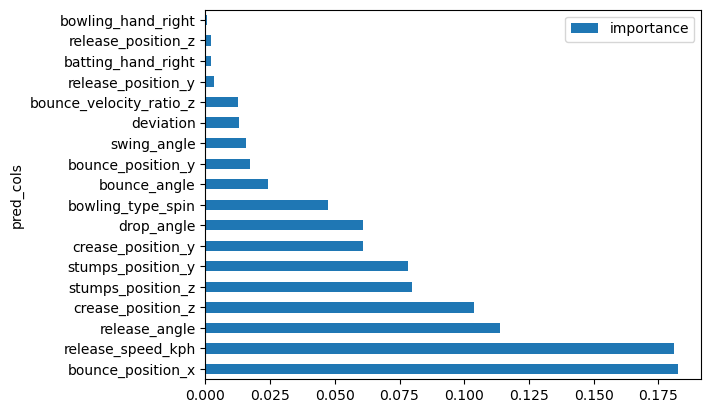

In [62]:
f_i = []
d_l =[]
train_x_df,test_x_df,train_y_df,test_y_df = get_modeling_data_sets(df,standardize_feat=False)

rf= RandomForestClassifier(max_depth=5,n_estimators=100,oob_score=True,n_jobs=10 )

rf.fit(train_x_df,train_y_df)
print('train score',rf.score(train_x_df,train_y_df))
print('test score',rf.score(test_x_df,test_y_df))
print('oobscore',rf.oob_score_)

pred_y_labels=rf.predict(test_x_df)
pred_y_probs=rf.predict_proba(test_x_df)

d={}
for val in zip(rf.feature_importances_,feature_cols):
    d[val[1]]=val[0]
fi=pd.DataFrame()
fi['pred_cols']=feature_cols
fi['importance']=rf.feature_importances_
f_i.append({'rf':fi})

d_l.append(sorted(d.items(),key = lambda x:x[1],reverse=True))

i=0
colormap=np.repeat(['viridis','ocean','rainbow'],len(f_i))
for fi,i in zip(f_i,range(len(colormap))):
        for k,v in fi.items():
                print(k,v)
                v.sort_values('importance',ascending=False)[0:20].set_index('pred_cols').plot(kind='barh')
[print (k,v) for k,v in d_l[0]]

## RF model with max_depth=10,n_estimators=200

In [63]:
f_i = []
d_l =[]
train_x_df,test_x_df,train_y_df,test_y_df = get_modeling_data_sets(df,standardize_feat=False)

(145701, 18) (48568, 18) (145701,) (48568,) 


train score 0.46344911840001096
test score 0.4321569757865261
oobscore 0.43200115304630715
bounce_position_x 0.13262377389996016
release_speed_kph 0.10677304412831198
release_angle 0.07915112409284726
stumps_position_y 0.07667304629850927
crease_position_z 0.07630600341441847
crease_position_y 0.07548801014583982
stumps_position_z 0.0692041307932588
drop_angle 0.05700609120346987
bounce_angle 0.05323861294965978
swing_angle 0.05221578575744561
deviation 0.05144590878880706
bounce_position_y 0.04291954328507052
bounce_velocity_ratio_z 0.03956514789443708
release_position_y 0.033821026237311626
release_position_z 0.029710333878080815
bowling_type_spin 0.014497477694939668
batting_hand_right 0.005382766658405412
bowling_hand_right 0.003978172879226932
bounce_position_x 0.13262377389996016
release_speed_kph 0.10677304412831198
release_angle 0.07915112409284726
stumps_position_y 0.07667304629850927
crease_position_z 0.07630600341441847
crease_position_y 0.07548801014583982
stumps_position_z

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

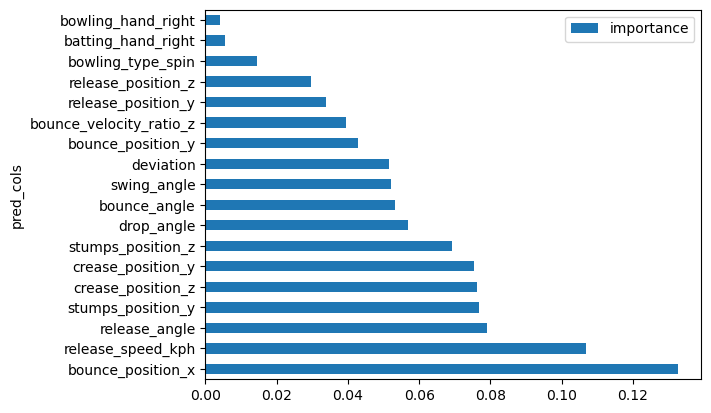

In [64]:
rf= RandomForestClassifier(max_depth=10,n_estimators=200,oob_score=True,n_jobs=20)

rf.fit(train_x_df,train_y_df)
print('train score',rf.score(train_x_df,train_y_df))
print('test score',rf.score(test_x_df,test_y_df))
print('oobscore',rf.oob_score_)

pred_y_labels=rf.predict(test_x_df)
pred_y_probs=rf.predict_proba(test_x_df)

d={}
for val in zip(rf.feature_importances_,feature_cols):
    d[val[1]]=val[0]
fi=pd.DataFrame()
fi['pred_cols']=feature_cols
fi['importance']=rf.feature_importances_
f_i.append({'rf':fi})

d_l.append(sorted(d.items(),key = lambda x:x[1],reverse=True))
[print (k,v) for k,v in d_l[0]]

i=0
colormap=np.repeat(['viridis','ocean','rainbow'],len(f_i))
for fi,i in zip(f_i,range(len(colormap))):
        for k,v in fi.items():
                v.sort_values('importance',ascending=False)[0:20].set_index('pred_cols').plot(kind='barh')
[print (k,v) for k,v in d_l[0]]

In [65]:
## From feature importance , bounce_position_x (Length of the ball plays a critical role, and height of the ball at crease or stump level,speed,swing play ra role)

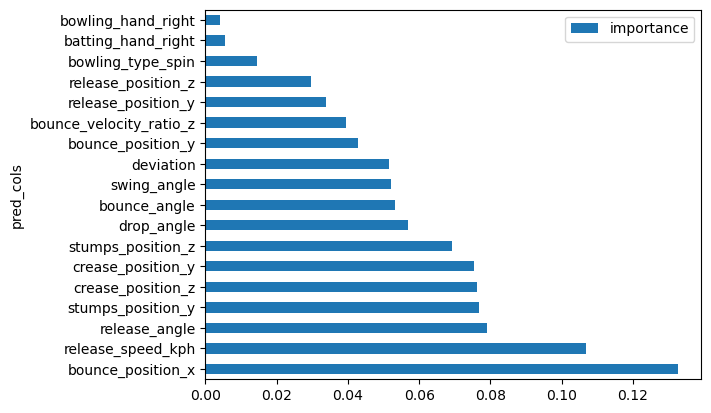

In [66]:
i=0
colormap=np.repeat(['viridis','ocean','rainbow'],len(f_i))
for fi,i in zip(f_i,range(len(colormap))):
        for k,v in fi.items():
                v.sort_values('importance',ascending=False)[0:20].set_index('pred_cols').plot(kind='barh')


## Observations from Feature Importance
- bounce_position_x  has the highest importance. It implies that ball length(good,short,full toss) play a critical role discriminating runs scored
- Similar z and y coordinates of crease,stump (ball is close to stumps or far and the height of the ball) play a role
- swing_angle and deviation play a role, although this classification model is meant for all categories (runs=0,1,2,3,4,5,6,wicket)

In [67]:
ts = get_test_results(pred_y_labels,pred_y_probs,test_x_df,rf.classes_)

<AxesSubplot:ylabel='runs'>

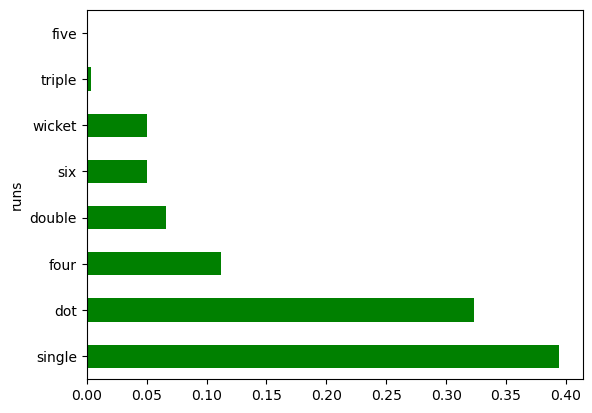

In [68]:
ts.runs.value_counts(normalize=True).plot(kind='barh',color='green')


<AxesSubplot:ylabel='pred_label'>

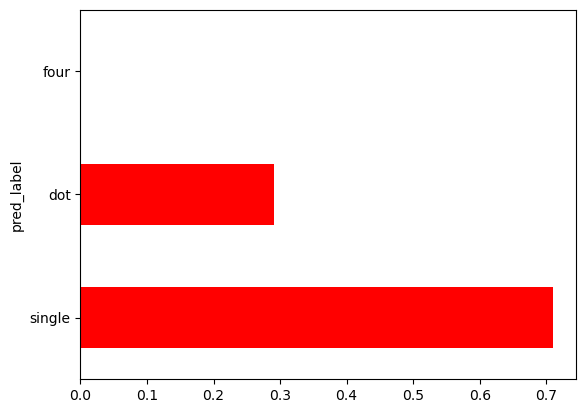

In [69]:
ts.pred_label.value_counts(normalize=True).plot(kind='barh',color='red')

## Entropy Measure as equivalent for Variance of actual distribution

- Entropy is the amount of disorder in a variable . It is equal to Sigma p*log(p)

In [70]:
p = ts.runs.value_counts(normalize=True).values
- np.sum(p * np.log(p))

1.4799593493120264

## Entropy as Measure as equivalent for Variance of pred distribution

- 0.607388378123068 might seem reasonable but the pred distribution is skewed towards singles and dots. So it is a bit less disordered. 
- Let us look at JS divergence as we go as a better measure comparing the distributions

In [71]:
p = ts.pred_label.value_counts(normalize=True).values
- np.sum(p * np.log(p))

0.6035339873212631

## Measuring DIfference/Variance between two distributions- JS Divergence

- KL divergence compares the divergence of one distribution over the other by calculating relative entropy. However the upper bound is not bounded.
- KL divergence is not symmetrical
- JS divergence compares the divergence of two distributions  from one the other and vice versa
- JS divergence is symmetrical
- Most importantly JS Divergence is bounded value between 0 and 1 (base2)   or btw 0 and 0.69(base e)
- The lower JS Divergence the better
- Below result indicates that the two distributions diverge by 0.74 which indicates not the best possible result. It can be b
- Particularly since 3's , 5's and wickets are rare, the distributions can be __calibrated__ 

In [72]:
lb = LabelBinarizer()
lb.fit(rf.classes_)

label_bin_actual = lb.transform(ts.runs)

In [73]:
distance.jensenshannon(label_bin_actual, ts[rf.classes_].values,axis=1,base=2)

array([0.65401551, 0.49445981, 0.89473065, ..., 0.89603138, 0.59551117,
       0.66771694])

In [74]:
np.mean( distance.jensenshannon(label_bin_actual, ts[rf.classes_].values,axis=1,base=2) )

0.7111030232955691

## Gradient Boosting Classifier is promising but takes a lot of time for convergence

In [75]:
# rf= GradientBoostingClassifier(max_depth=5,n_estimators=100)

# rf.fit(train_x_df,train_y_df)
# print('train score',rf.score(train_x_df,train_y_df))
# print('test score',rf.score(test_x_df,test_y_df))
# #             print('oobscore',rf.oob_score_)

# predicted_y=rf.predict(test_x_df)
# result=test_x_df.assign(actual_y=test_y_df,predicted_y=predicted_y)

# d={}
# for val in zip(rf.feature_importances_,feature_cols):
#     d[val[1]]=val[0]
# fi=pd.DataFrame()
# fi['pred_cols']=feature_cols
# fi['importance']=rf.feature_importances_
# f_i.append({'rf':fi})

# #     print('RF Feature Importance')
# d_l.append(sorted(d.items(),key = lambda x:x[1],reverse=True))




In [76]:
            
#             rf= GradientBoostingClassifier(max_depth=5,n_estimators=100)

#             rf.fit(train_x_df,train_y_df)
#             print('train score',rf.score(train_x_df,train_y_df))
#             print('test score',rf.score(test_x_df,test_y_df))
# #             print('oobscore',rf.oob_score_)

#             predicted_y=rf.predict(test_x_df)
#             result=test_x_df.assign(actual_y=test_y_df,predicted_y=predicted_y)

#             d={}
#             for val in zip(rf.feature_importances_,feature_cols):
#                 d[val[1]]=val[0]
#             fi=pd.DataFrame()
#             fi['pred_cols']=feature_cols
#             fi['importance']=rf.feature_importances_
#             f_i.append({'rf':fi})
           
#         #     print('RF Feature Importance')
#             d_l.append(sorted(d.items(),key = lambda x:x[1],reverse=True))




In [77]:
# d_l.append(sorted(d.items(),key = lambda x:x[1],reverse=True))

In [78]:
# i=0
# colormap=np.repeat(['viridis','ocean','rainbow'],len(f_i))
# for fi,i in zip(f_i,range(len(colormap))):
#         for k,v in fi.items():
#                 print(k,v)
#                 v.sort_values('importance',ascending=False)[0:20].set_index('pred_cols').plot(kind='barh')

   

In [79]:
ts.query('double > wicket ').shape[0] /test_results.shape [0]

0.9054109701861308

In [80]:
ts.query('wicket > double ').runs.value_counts()

runs
dot       1810
single    1415
four       475
wicket     387
six        250
double     241
triple      16
Name: count, dtype: int64

## Label based classification metrics are of not much use here
- As dataset is imbalanced and accuracy not meaningful
- weighted accuracy and F1 score 
- We discuss __Brier Score__

In [81]:
test_results = get_test_results(pred_y_labels,pred_y_probs,test_x_df,rf.classes_)

C:\Users\advitha\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\advitha\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         dot       0.43      0.39      0.41     15697
      double       0.00      0.00      0.00      3214
        five       0.00      0.00      0.00         8
        four       0.00      0.00      0.00      5431
      single       0.43      0.78      0.56     19143
         six       0.00      0.00      0.00      2457
      triple       0.00      0.00      0.00       179
      wicket       0.00      0.00      0.00      2439

    accuracy                           0.43     48568
   macro avg       0.11      0.15      0.12     48568
weighted avg       0.31      0.43      0.35     48568



C:\Users\advitha\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


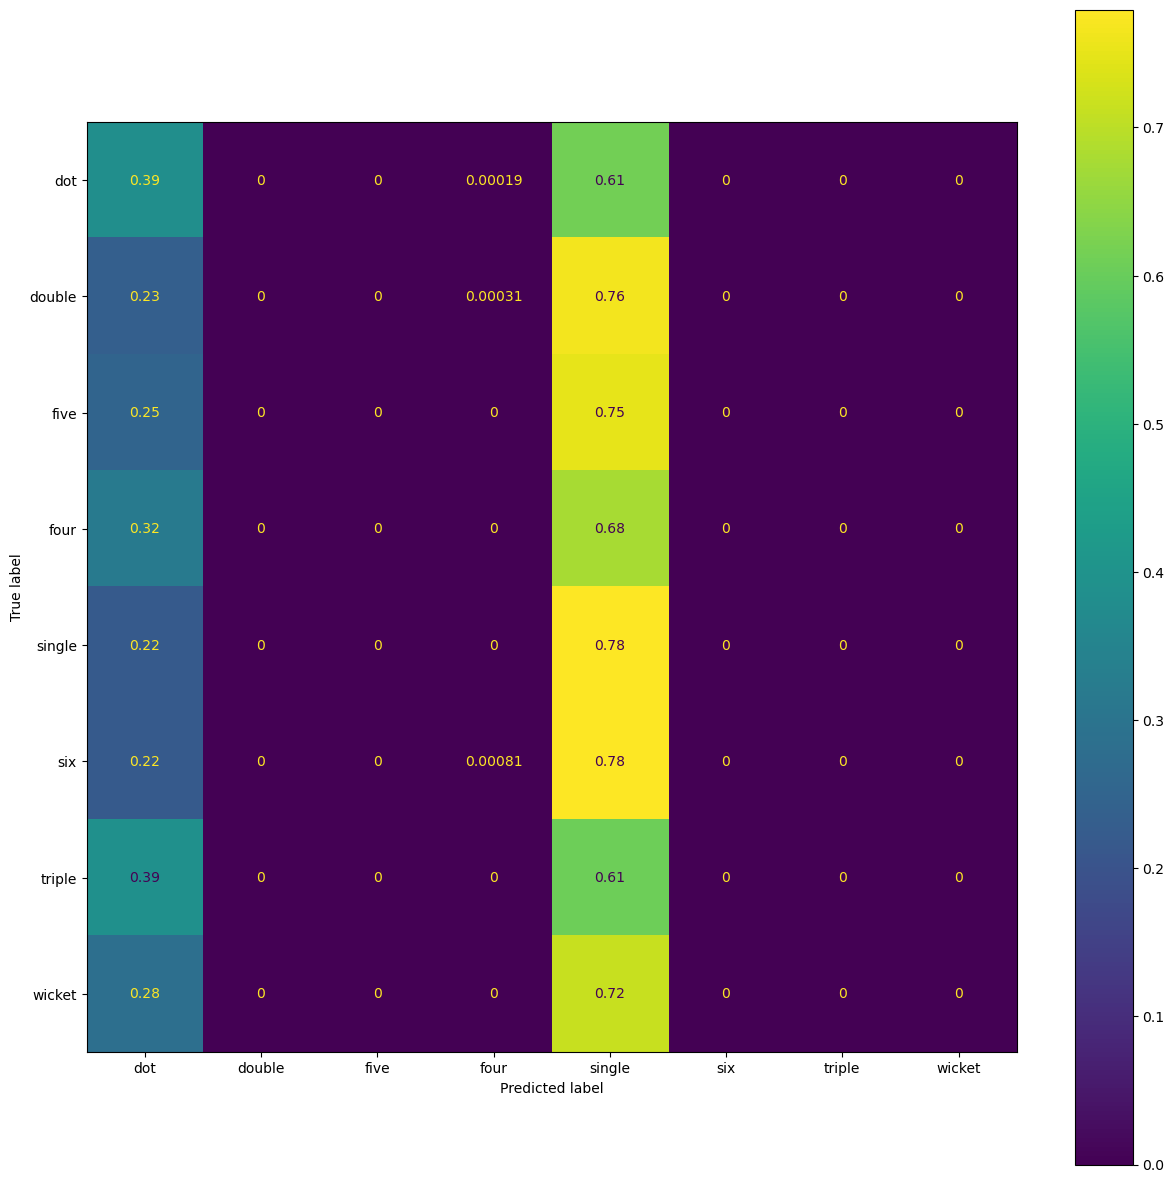

In [82]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay


actual_list = test_results.runs
predicted_list = pred_y_labels

classes = rf.classes_

print(classification_report(actual_list,predicted_list))
    
fig, ax = plt.subplots(figsize=(15,15))
cm=confusion_matrix(actual_list,predicted_list,normalize='true',labels=classes)
    
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes).plot(ax=ax)


## Multiclass Brier Score
- Brier score is more suitable for __imbalanced__ dataset

- Brier score is the difference between probabilties of each category squared and averaged over all rows
- Brier score can be mathematically decomposed into Reliability - Resolution + Uncertainty.
- The uncertainty cancels out when using Brier skill score
- __Brier Skill Score__ is the relative improvement our model offers over a baseline model(or a No Skill model). Here since the number of runs , wickets are heavily imbalanced classes, BSS against a baseline model would give an good indicator of the performance



In [83]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(rf.classes_)

label_bin_actual = lb.transform(test_results.runs)


In [84]:
brier_score = np.mean((np.array(pred_y_probs) - np.array(label_bin_actual) ) ** 2 )
brier_score

0.08710965201733761

In [85]:
brier_score = np.mean((np.array(pred_y_probs) - np.array(label_bin_actual) ) ** 2 )
brier_score

0.08710965201733761

#### Instead of taking no-skill model,  I have taken a Baseline/reference model  which just predicts the static weights of various categories from the population

In [86]:
baseline_model = train_y_df.value_counts(normalize=True).to_frame().T
baseline_preds = np.repeat(baseline_model.values,test_results.shape[0],axis=0)

In [87]:
brier_score_baseline = np.mean((np.array(baseline_preds) - np.array(label_bin_actual) ) ** 2 )
brier_score_baseline

0.11557830769403703

## Brier Skill Score

In [88]:
brier_skill_score = (brier_score_baseline- brier_score)/brier_score_baseline
brier_skill_score

0.24631486863488816

### RF Classifer is 25% better than a baseline model

## Ignorance score

- __Ignorance score__ is also a proper scoring rule and useful for measuring proabilistic forecasts.It is equal to the sum of logs of individual proabilities of each class

- It is like entropy. The lower the better


In [89]:
pred_y_probs_copy = pred_y_probs.copy()
pred_y_probs_copy[pred_y_probs_copy < 0.01 ] = 0.01
## to prevent division by zero

In [90]:
- np.sum(np.log(np.array(pred_y_probs_copy))) / test_results.shape[0]

22.392776797757868

In [91]:
rf.classes_

array(['dot', 'double', 'five', 'four', 'single', 'six', 'triple',
       'wicket'], dtype=object)

## Expected Runs Calculation

In [92]:
# # pd.DataFrame(train_y_df.value_counts(normalize=True).values)
# exp_train_df = pd.DataFrame([train_y_df.value_counts(normalize=True).tolist()], columns=train_y_df.value_counts(normalize=True).index)

# exp_train_df['expected_runs'] = exp_train_df['wicket'] * 0 + exp_train_df['dot'] * 0 + exp_train_df['double'] * 2 + exp_train_df['five'] *5 + exp_train_df['four'] * 4 + exp_train_df['single'] *1 +exp_train_df['six'] * 6 + exp_train_df['triple'] * 3
# exp_train_df

In [93]:
test_results['expected_runs'] = test_results['wicket'] * 0 + test_results['dot'] * 0 + test_results['double'] * 2 + test_results['five'] *5 + test_results['four'] * 4 + test_results['single'] *1 +test_results['six'] * 6 + test_results['triple'] * 3

test_results

,release_speed_kph,swing_angle,deviation,release_position_y,release_position_z,bounce_position_y,bounce_position_x,crease_position_y,crease_position_z,stumps_position_y,stumps_position_z,bounce_velocity_ratio_z,release_angle,drop_angle,bounce_angle,batting_hand_right,bowling_hand_right,bowling_type_spin,runs,pred_label,dot,double,five,four,single,six,triple,wicket,expected_runs
172767,141.71,2.36,-0.03,-0.60,1.91,0.37,2.27,0.46,0.14,0.56,0.27,-0.70,-4.38,-9.18,6.69,1,1,0,dot,single,0.365555,0.086641,0.000123,0.123855,0.383008,0.010970,0.002133,0.027714,1.124547
126988,144.02,-0.12,1.11,0.26,1.99,0.35,7.10,0.50,0.81,0.53,0.94,-0.71,-8.22,-11.45,8.98,0,0,0,dot,dot,0.588708,0.044301,0.000132,0.124058,0.170275,0.024542,0.003834,0.044149,0.914525
70652,87.54,0.29,-3.05,-1.08,2.09,-0.34,6.15,-0.30,0.65,-0.28,0.68,-0.52,-1.52,-17.75,11.41,0,0,1,four,single,0.333941,0.062853,0.000101,0.076694,0.443549,0.042748,0.003114,0.037000,1.142366
186062,137.70,0.77,0.24,-0.65,2.01,-0.78,7.67,-0.78,0.52,-0.78,0.55,-0.46,-8.88,-11.89,5.82,1,1,0,wicket,dot,0.519961,0.050669,0.000004,0.138971,0.229734,0.024273,0.003788,0.032601,1.043975
14823,123.48,0.26,-1.06,-0.91,2.03,-0.42,7.64,-0.22,0.68,-0.18,0.73,-0.53,-7.76,-13.10,7.90,1,1,0,single,single,0.382379,0.058866,0.000229,0.084829,0.391727,0.037956,0.003050,0.040964,1.086811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18432,121.26,0.83,-0.94,-0.84,2.05,-0.24,8.92,0.19,0.98,0.26,1.05,-0.60,-9.58,-14.50,9.88,1,1,0,single,single,0.233428,0.077536,0.000232,0.109901,0.465169,0.060985,0.003660,0.049090,1.437891
131302,95.74,1.01,-0.01,-0.77,1.95,-0.70,0.99,-0.70,0.09,-0.68,0.22,-0.70,0.50,-13.74,11.44,1,0,1,dot,single,0.317884,0.089317,0.000010,0.115064,0.428745,0.025076,0.005468,0.018437,1.234543
168189,128.50,-1.39,-0.44,0.30,1.74,0.15,6.51,-0.03,0.58,-0.08,0.65,-0.66,-6.09,-10.33,7.35,0,0,0,wicket,dot,0.357825,0.065882,0.000202,0.101728,0.347667,0.047161,0.004061,0.075475,1.182502
14147,106.05,-1.01,1.70,0.56,2.19,-0.22,3.49,-0.29,0.45,-0.33,0.64,-0.70,-2.83,-14.07,11.76,1,0,0,single,single,0.224100,0.078742,0.000052,0.106688,0.447076,0.079395,0.004605,0.059341,1.521760


<AxesSubplot:ylabel='Frequency'>

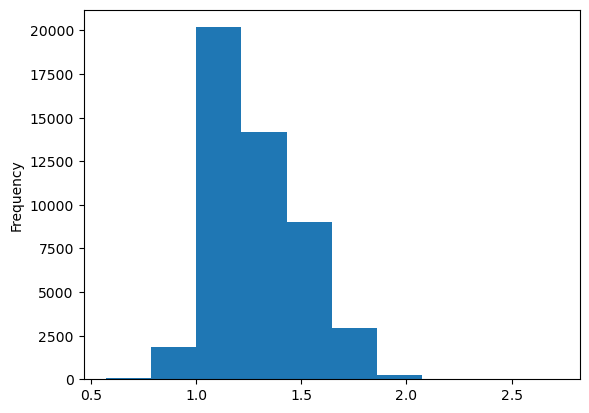

In [94]:
test_results.expected_runs.plot(kind='hist')

## Stacking Classifiers

- Can be used to stack multiple weak learners and build a strong learner from weak learner

In [95]:
from sklearn.ensemble import StackingClassifier

train_x_df,test_x_df,train_y_df,test_y_df = get_modeling_data_sets(df,standardize_feat=False)

estimators = [
    ('rf1', RandomForestClassifier(n_estimators=200, max_depth = 10)),
    ('rf2', RandomForestClassifier(n_estimators=100, max_depth = 5)),
#     ('rf3',  RandomForestClassifier(n_estimators=150, max_depth = 7,n_jobs=10))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(max_iter=1000)
)
clf.fit(train_x_df,train_y_df)
clf.score(train_x_df,train_y_df),  clf.score(test_x_df,test_y_df)

(145701, 18) (48568, 18) (145701,) (48568,) 


(0.48607765217809074, 0.43716027013671555)

## Miscallenous - SVM, One-One,GB, XGB,PCA
- As discussed since the dataset categories are not linearly separable, SVM is a good alternative to try out

In [96]:
#SVM
from sklearn.svm import SVC
from sklearn.svm import SVR

from sklearn.svm import LinearSVC

In [97]:
train_x_df,test_x_df,train_y_df,test_y_df = get_modeling_data_sets(df,standardize_feat=True)


(145701, 18) (48568, 18) (145701,) (48568,) 


In [98]:
# svc= SVC(class_weight='balanced')
# svc.fit(train_x_df,train_y_df)
# print('train score',svr.score(train_x_df,train_y_df))
# print('test_score',svr.score(test_x_df,test_y_df))

In [99]:
# svc= SVC()
# svc.fit(train_x_df,train_y_df)
# print('train score',svr.score(train_x_df,train_y_df))
# print('test_score',svr.score(test_x_df,test_y_df))

In [100]:
from sklearn import preprocessing
from sklearn.decomposition import PCA


### Since features are related like release angle , drop angle I have tried PCA
- PCA needs 15 components for explaining 99% of variance
- did not provide much improvement 

In [101]:
pca_data = preprocessing.scale(train_x_df)
pca = PCA(n_components=15)
train_x_df = pca.fit_transform(pca_data)
test_x_df = pca.transform(test_x_df)
pr_var = pca.explained_variance_ratio_
cum_pr = np.cumsum(pca.explained_variance_ratio_)
# ind = ["Proportion of variance", "Cumulative proportion of variance"]
# cols = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8"]
# pd.DataFrame(np.vstack((pr_var, cum_pr)), ind, columns=cols)


C:\Users\advitha\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [102]:
cum_pr

array([0.23189193, 0.41409189, 0.58792596, 0.68342445, 0.75549414,
       0.82391002, 0.87693747, 0.91429622, 0.94262238, 0.9680016 ,
       0.9799489 , 0.98679135, 0.99099157, 0.99433789, 0.99704406])

### XGB - incompatibility issues with my local numpy versions

In [103]:
# from xgboost import XGBClassifier

# bst = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=1, objective='multi:softprob')
# # fit model
# bst.fit(train_x_df, train_y_df)
# # make predictions
# preds = bst.predict(test_x_df)